In [ ]:
# credits
# https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751
# https://medium.com/@js2441995/natural-language-processing-using-tfidf-word2vec-and-bert-825cc2c663c3

In [1]:
import pandas as pd
import numpy as np

import gensim
from gensim.models import Word2Vec

from sklearn.neighbors import NearestNeighbors

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from adjustText import adjust_text

from nltk.tokenize import word_tokenize

# UNCOMMENT TO DOWNLOAD IF THE IMPORT FAILS
#spacy.cli.download("en_core_web_lg")
import en_core_web_lg

from time import asctime

import multiprocessing
from ast import literal_eval

from sklearn.metrics.pairwise import cosine_similarity

print("Genism Version: ", gensim.__version__)

Genism Version:  4.3.0


In [2]:
print("Begin : ", asctime())

Begin :  Sun Apr 30 04:32:43 2023


In [3]:
df = pd.read_csv("../data/master-thesis-dataset-large_specChars_rm_and_wo_foods_or_keywords_wbigrams_label.csv")
df['processed_text_tokens'] = df['processed_text_tokens'].apply(eval)
df = df[df.Text_Term_Count>0]

questions_df = pd.read_csv("../data/questions.csv")
questions = questions_df.question.values.tolist()
questions_df['processed_question_tokens'] = questions_df.processed_question_tokens.apply(eval)

In [4]:
df.head(1)

Full_Vintage_Name Winery_Name Vintage_Year Short_Wine_Name  Type_ID  \
0  Champalou Vouvray 2021   Champalou         2021         Vouvray      2.0   

    Region Country  Price Currency    Wine_ID  ...  polarity  subjectivity  \
0  Vouvray  France  23.95      USD  1172337.0  ...      0.08          0.52   

  Pos_or_Neg Weighted_Rating  \
0      happy        2.252295   

                                                text  \
0  🧐 light yellow\n🤥  citrus\n😛 honey, pear, citr...   

                                  processed_text_str  \
0  light_yellow citrus honey pear_citrus apple un...   

                               processed_text_tokens  Text_Term_Count  \
0  [light_yellow, citrus, honey, pear_citrus, app...               14   

   Text_Char_Count        Label2  
0              101  Chenin_Blanc  

[1 rows x 52 columns]

In [5]:
questions_df.head()

question  \
0  I want to split a bottle of wine with my frien...   
1  Tonight I will be eating pasta at the Italian ...   
2                  I like Cabernets from Napa Valley   
3  I'm looking to try something different for my ...   
4                          I don't know what I want.   

                              processed_question_str  \
0  want split bottle friend birthday likely eat s...   
1  tonight eat pasta italian_restaurant dinner nt...   
2                          like cabernet napa_valley   
3  look try_something_different dinner tonight wh...   
4                                       nt know want   

                           processed_question_tokens  
0  [want, split, bottle, friend, birthday, likely...  
1  [tonight, eat, pasta, italian, restaurant, din...  
2                     [like, cabernet, napa, valley]  
3  [look, try, something, different, dinner, toni...  
4                                   [nt, know, want]

In [6]:
print('nulls of essential column post-filter', df.processed_text_str.isnull().sum())

nulls of essential column post-filter 0


In [7]:
doc_tokens = df.processed_text_tokens

In [8]:
doc_tokens

0         [light_yellow, citrus, honey, pear_citrus, app...
1         [top_quality, grape, meet, expertise, winemake...
2         [young, good, 42, potential, become, outstandi...
3         [great, balance, alcohol, integration, quite_c...
4         [limited, experience, excellent, representatio...
                                ...                        
255792    [medium_intensity_aromas, flavor, ripe, red_be...
255793    [medium_intensity_aromas, flavor, ripe, black_...
255794    [medium_intensity_aromas, flavor, citrus, note...
255795    [early, morning, cold, temperature, harvest, c...
255796    [5, deepdeep, brick, shyer, nose, blueberry_bl...
Name: processed_text_tokens, Length: 255797, dtype: object

In [9]:
asctime()

'Sun Apr 30 04:32:59 2023'

In [10]:
word2vec_model = Word2Vec(doc_tokens, 
                          window=10, 
                          vector_size=768,
                          min_count=1, 
                          workers=12
                         )

In [11]:
asctime()

'Sun Apr 30 04:34:09 2023'

In [12]:
print(word2vec_model)

Word2Vec<vocab=140383, vector_size=768, alpha=0.025>


In [13]:
len(word2vec_model.wv.key_to_index.keys()) # vocab size: 48k without preprocessing. 28k with preprocessing

# previously word2vec_model.wv.vocab

140383

In [14]:
len(word2vec_model.wv.key_to_index) # also vocab size

140383

In [15]:
word2vec_model.wv.index_to_key[0:5]

['nose', 'finish', 'good', 'nice', 'palate']

In [16]:
'pinot' in word2vec_model.wv.index_to_key # test if word in vocab

True

In [17]:
'pinot_noir' in word2vec_model.wv.index_to_key # test if word in vocab

True

In [18]:
word2vec_model.wv.most_similar('pinot')

[('pinot_noir', 0.900813639163971),
 ('pn', 0.8482646942138672),
 ('oregon_pinot', 0.8217483758926392),
 ('california_pinot', 0.7056727409362793),
 ('pinot_noirs', 0.6940522789955139),
 ('sonoma_pinot', 0.6387885212898254),
 ('old_world', 0.6351417303085327),
 ('oregon', 0.628449559211731),
 ('cola', 0.6277621984481812),
 ('beaujolais', 0.6266056895256042)]

In [19]:
word2vec_model.wv.most_similar(['pinor', 'noir'])

[('raul', 0.8896815776824951),
 ('gatos', 0.8892183303833008),
 ('thwm', 0.8882198929786682),
 ('charrdonnay', 0.8859543800354004),
 ('peluda', 0.8837878108024597),
 ('gustan', 0.8813310265541077),
 ('vuela', 0.8807030320167542),
 ('hybrid', 0.8774245381355286),
 ('rita_hill', 0.877202570438385),
 ('macgregor', 0.8738575577735901)]

In [20]:
word2vec_model.wv.most_similar(['pinor', 'grigio'])

[('hater', 0.9179313778877258),
 ('natural_wine', 0.9171608090400696),
 ('pinto', 0.9155299067497253),
 ('porch_pounder', 0.9145740270614624),
 ('give_come', 0.9087222218513489),
 ('white_portugal', 0.9085002541542053),
 ('grape_unabashed', 0.9076746702194214),
 ('sauvignon_blancs', 0.9043890237808228),
 ('sauvblanc', 0.901361882686615),
 ('nontraditional', 0.896743655204773)]

In [21]:
# people don't like when cab sauv taste like gp. what does Word2Vec say?
word2vec_model.wv.most_similar(['cabernet', 'sauvignon', 'green', 'pepper'])

[('punchy', 0.6504043936729431),
 ('operatic', 0.6112182140350342),
 ('samuse', 0.6000677943229675),
 ('mouthfeel_like', 0.5799162983894348),
 ('complicate', 0.5748944878578186),
 ('primarily', 0.5728943347930908),
 ('la_bouche_confirme', 0.5728102922439575),
 ('transparent_ruby_hue', 0.5703284740447998),
 ('pallette_secondary_note', 0.5697966814041138),
 ('presence_secondary', 0.567483127117157)]

In [22]:
questions[1]

"Tonight I will be eating pasta at the Italian restaurant for dinner. I don't like sweet wines."

In [23]:
q2_tokens = questions_df.processed_question_tokens[1]

In [24]:
word2vec_model.wv.most_similar(q2_tokens)

[('choice', 0.8022410273551941),
 ('table', 0.7891291379928589),
 ('party', 0.7796248197555542),
 ('mood', 0.7783274054527283),
 ('home', 0.7757233381271362),
 ('wife', 0.7750363349914551),
 ('larvf', 0.7683528065681458),
 ('occasion', 0.7671074867248535),
 ('make_want', 0.7637868523597717),
 ('anything', 0.7571685910224915)]

In [25]:
questions[11]

'I like Cabernet Sauvignon s from Napa Valley'

In [26]:
q12_tokens = questions_df.processed_question_tokens[11]
try:
    print(word2vec_model.wv.most_similar(q12_tokens))
except KeyError as exp:
    print(exp)

[('california', 0.8671823143959045), ('napa_valley', 0.7996761202812195), ('sonoma', 0.7939150929450989), ('varietal', 0.7822075486183167), ('californian', 0.7757009267807007), ('american', 0.7755724787712097), ('exception', 0.775513231754303), ('french', 0.7722676396369934), ('bordeaux', 0.7611594796180725), ('syrahs', 0.7546226382255554)]


In [27]:
word2vec_model.vector_size

768

In [28]:
word2vec_model.wv.index_to_key[0:24]

['nose',
 'finish',
 'good',
 'nice',
 'palate',
 'cherry',
 'note',
 'dry',
 'fruit',
 'taste',
 'great',
 'oak',
 'long',
 'acidity',
 'balance',
 'smooth',
 'light',
 'tannin',
 'vanilla',
 'well',
 'red',
 'flavor',
 'hint',
 'like']

In [29]:
word2vec_model.wv.get_vector('cabernet')[0:10]

array([-0.0943943 , -0.5596993 ,  0.5420585 , -0.01582416, -0.14479971,
       -0.09228613, -0.35989594, -0.29550365, -0.43879867, -0.8877662 ],
      dtype=float32)

In [30]:
word2vec_model.wv.vectors

array([[ 5.5582303e-01,  9.5144099e-01, -3.8433391e-01, ...,
         8.4321785e-01,  8.6040854e-01,  9.1935146e-01],
       [ 1.3368505e+00,  4.4177926e-01,  4.5035888e-02, ...,
         5.0433123e-01,  9.2923723e-02,  2.3814173e+00],
       [ 7.4919134e-01, -1.1725395e-01, -8.3745193e-01, ...,
        -2.6588523e-01,  5.5556750e-01,  6.2185150e-01],
       ...,
       [-8.4688598e-03,  7.3787454e-04, -1.6773650e-03, ...,
        -7.7584437e-03, -1.4566024e-03, -8.5095764e-04],
       [-7.6149469e-03,  1.1694981e-02, -6.3679181e-03, ...,
        -5.6409640e-03, -1.7710300e-03, -1.1549778e-02],
       [ 7.3301728e-04, -5.9595611e-04, -5.9107798e-03, ...,
        -5.1902113e-03, -4.1617751e-03, -1.6662769e-03]], dtype=float32)

In [31]:
words = word2vec_model.wv.index_to_key

In [32]:
words_and_rank = word2vec_model.wv.key_to_index

In [33]:
words_and_rank_df = pd.DataFrame([words_and_rank.values(), words_and_rank.keys()]).T
words_and_rank_df.rename(columns={0: 'rank', 1:'term'}, inplace=True)

In [34]:
pd.DataFrame(words_and_rank_df.set_index('term').head(25))#.columns#['rank']

rank
term        
nose       0
finish     1
good       2
nice       3
palate     4
cherry     5
note       6
dry        7
fruit      8
taste      9
great     10
oak       11
long      12
acidity   13
balance   14
smooth    15
light     16
tannin    17
vanilla   18
well      19
red       20
flavor    21
hint      22
like      23
plum      24

In [35]:
asctime()

'Sun Apr 30 04:34:15 2023'

In [36]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = word2vec_model.wv.vectors
#vector_list = word2vec_model.wv.get_mean_vector(word_vec_df.head(25).index)

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in word2vec_model.wv.index_to_key]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a DataFrame
word_vec_dict = dict(word_vec_zip)
word_vec_df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
word_vec_df.head(25)

0         1         2         3         4         5         6    \
nose     0.555823  0.951441 -0.384334  0.248535 -0.812831 -0.038077  0.205197   
finish   1.336851  0.441779  0.045036 -0.504095 -0.661173  0.490754  0.269822   
good     0.749191 -0.117254 -0.837452 -0.479083 -0.571457 -0.316191  0.344296   
nice     0.836305  0.039372 -0.865503 -0.913272 -1.211541 -0.567888  0.346483   
palate   0.516028  0.466343 -0.189758  0.346448 -1.070395  0.822388  0.392864   
cherry   2.175149 -0.366645  0.544481 -1.875129 -0.028930 -0.172924 -0.511537   
note    -0.284730  0.843148  0.077213  0.690391 -1.435775 -0.003238  0.114529   
dry      1.511192  0.675859 -0.457789 -0.678727 -0.932010  0.321925  0.459361   
fruit    0.256221  0.177210  0.177344 -0.225260 -0.571783  0.261580  0.283819   
taste    0.566631  0.001472 -0.390396 -0.103061 -0.367462  0.128600  0.462531   
great    0.726615 -0.163954 -0.922435 -0.813968 -1.488403 -0.632103  0.468704   
oak      1.920286  0.553582 -0.560861 -0.833498 -0.361610  0.460490  0.015037   
long     0.877198  0.428867 -0.338543 -0.542966 -0.890365  0.239219  0.225527   
acidity -0.204244  0.184329  0.058448 -0.421529 -0.807298 -0.588011  1.065575   
balance  1.063644  1.311384 -0.226325 -1.145100 -0.611575  0.714143  1.334955   
smooth   0.780633 -0.145074  0.439905 -0.548963 -0.310340  0.225340  0.847342   
light    1.493221  0.477084 -0.525669 -1.356585 -0.038611  0.008864  0.184474   
tannin   1.670155  0.083379  0.054150 -2.007009  0.311037 -0.571946 -0.063234   
vanilla  0.520783  0.056329  0.234514  0.996593 -0.715822 -0.517982 -0.428827   
well     0.418494 -0.321713  0.436117 -0.704645 -0.109175 -0.230116 -0.248632   
red     -0.093585  1.009013 -0.079488 -0.367911 -0.863866 -0.126114  0.503813   
flavor   0.339719  0.050467  0.454434  0.110646 -1.564668  0.441356  0.029270   
hint     0.815881  0.413491 -0.475365 -0.549927 -1.218048  0.322445  0.248128   
like     0.147497  0.534542 -0.362431 -0.367926 -0.770698 -0.302008  0.633346   
plum     1.058141 -0.970060  0.253399 -1.168559  0.776490  1.046366 -0.041134   

              7         8         9    ...       758       759       760  \
nose     0.719132 -0.521084 -0.409076  ... -1.019551 -0.391662  0.444336   
finish  -0.618115  0.347660 -0.210342  ... -0.671236 -0.562515  0.043060   
good    -0.796633 -0.443478 -0.324868  ...  0.585136 -0.230874 -0.226253   
nice    -0.762759 -0.570314 -0.223433  ...  0.126006 -0.660728 -0.234117   
palate  -0.674019  0.710295 -0.521759  ... -0.969168 -1.047767 -0.823242   
cherry  -0.103020  0.150646  0.636201  ... -0.876270  0.018353 -1.547106   
note    -0.810933  0.251017 -0.524728  ... -0.114345 -0.629693 -0.987001   
dry     -0.078823 -0.534293 -0.248518  ... -0.657748 -0.033311 -0.037614   
fruit   -1.021477  0.477401 -1.098902  ...  0.280905 -0.788742 -0.705713   
taste   -0.409559 -0.763300 -0.285540  ... -0.079297 -0.548591  0.153613   
great   -1.119564 -0.371408 -0.970947  ...  0.167277 -0.237532 -0.293283   
oak     -0.686455 -0.049484 -1.021469  ... -0.916673 -0.624284  0.257992   
long    -0.460875  0.081598 -0.383283  ...  0.179497 -0.965306  0.168043   
acidity -0.337699  0.511861 -0.319332  ... -1.120630 -0.455002  0.064507   
balance -1.427144 -0.409462 -0.419328  ...  0.236625 -0.947145 -0.122938   
smooth  -0.755188 -1.183471 -0.353073  ...  0.023001  0.009221 -0.342112   
light   -0.322508 -0.580757  0.690894  ...  0.197748 -0.502452  0.468276   
tannin  -0.852129 -0.051065 -0.403894  ... -1.363843 -0.533798 -0.925039   
vanilla -0.450584  0.367506  0.053826  ...  0.163609 -0.457043 -0.322857   
well    -0.836206 -0.760817 -0.713651  ...  0.138728  0.055185  0.152543   
red     -0.593838  0.930096  0.438220  ... -1.623777  0.567080 -0.696871   
flavor  -0.669670 -0.080412 -0.327132  ... -0.852140 -0.894460 -0.720586   
hint    -0.274178 -0.340491  0.094641  ... -0.397404 -0.522784 -0.416827   
like    -0.544140  0.512444 -0.476653  ...  0.227510 -0.075593 -0.092634   
plum   

In [37]:
pd.DataFrame(word_vec_df.head(25).mean(axis=1), columns=['Word2Vec Mean'])

Word2Vec Mean
nose         -0.008985
finish        0.024021
good          0.034972
nice          0.028603
palate       -0.015298
cherry       -0.001448
note         -0.000154
dry           0.021036
fruit         0.002941
taste        -0.009898
great         0.028009
oak           0.027162
long         -0.003099
acidity       0.049661
balance       0.023474
smooth        0.037623
light         0.025358
tannin        0.017608
vanilla       0.013863
well          0.018342
red           0.020656
flavor        0.032686
hint         -0.016725
like          0.030080
plum         -0.014083

In [38]:
word_vec_df.index.rename('term', inplace=True)
pd.DataFrame(word_vec_df.head(25).mean(axis=1).groupby(level='term').mean(), columns=['Word2Vec Mean'])

Word2Vec Mean
term                  
acidity       0.049661
balance       0.023474
cherry       -0.001448
dry           0.021036
finish        0.024021
flavor        0.032686
fruit         0.002941
good          0.034972
great         0.028009
hint         -0.016725
light         0.025358
like          0.030080
long         -0.003099
nice          0.028603
nose         -0.008985
note         -0.000154
oak           0.027162
palate       -0.015298
plum         -0.014083
red           0.020656
smooth        0.037623
tannin        0.017608
taste        -0.009898
vanilla       0.013863
well          0.018342

In [39]:
asctime()

'Sun Apr 30 04:45:19 2023'

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


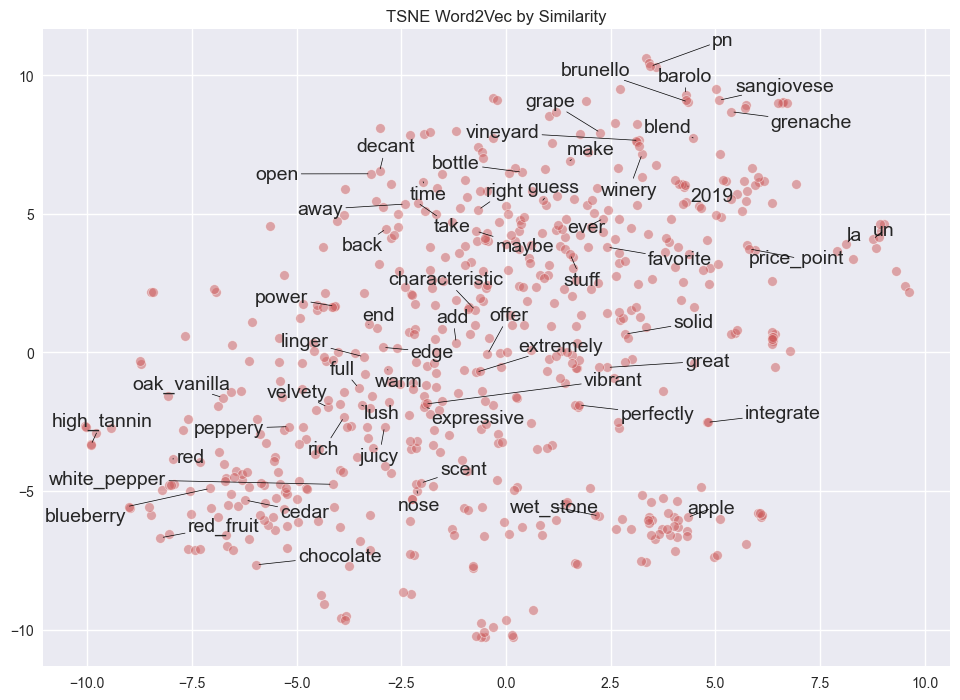

In [40]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(word_vec_df[:600])

sns.set()

plt.style.use('seaborn') 

# Initialize figure
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5, color='indianred')

texts = []
words_to_plot = list(np.arange(0, 600, 10)) # every 10th word in first 600 words

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], 
                          tsne_df[word, 1], 
                          word_vec_df.index[word],
                          fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.title('TSNE Word2Vec by Similarity')

plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


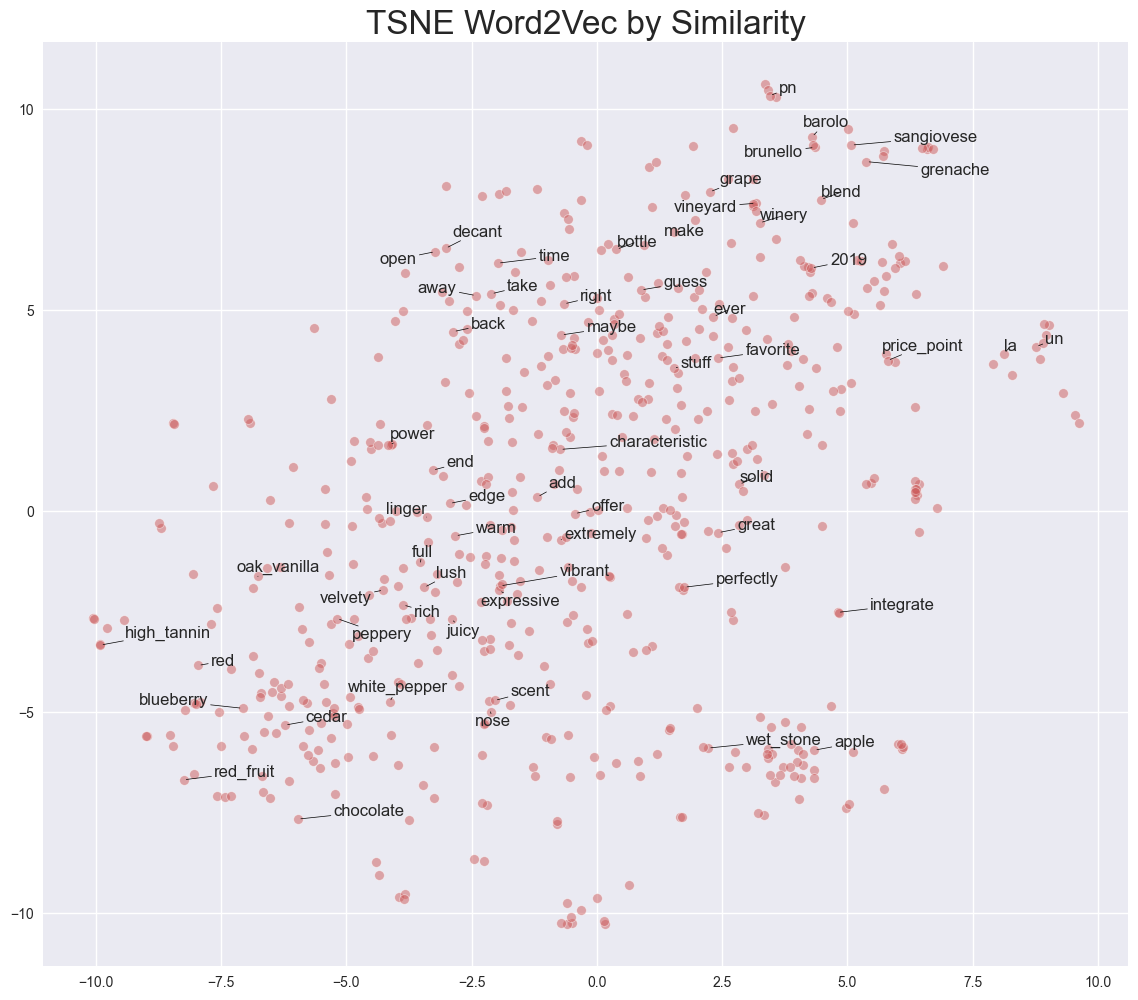

In [41]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(word_vec_df[:600])

sns.set()

plt.style.use('seaborn') 

# Initialize figure
fig, ax = plt.subplots(figsize = (14, 12))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5, color='indianred')

texts = []
words_to_plot = list(np.arange(0, 600, 10)) # every 10th word in first 600 words

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], 
                          tsne_df[word, 1], 
                          word_vec_df.index[word],
                          fontsize = 12))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2, 1), expand_text = (1, 2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.title('TSNE Word2Vec by Similarity', fontsize=24)

plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


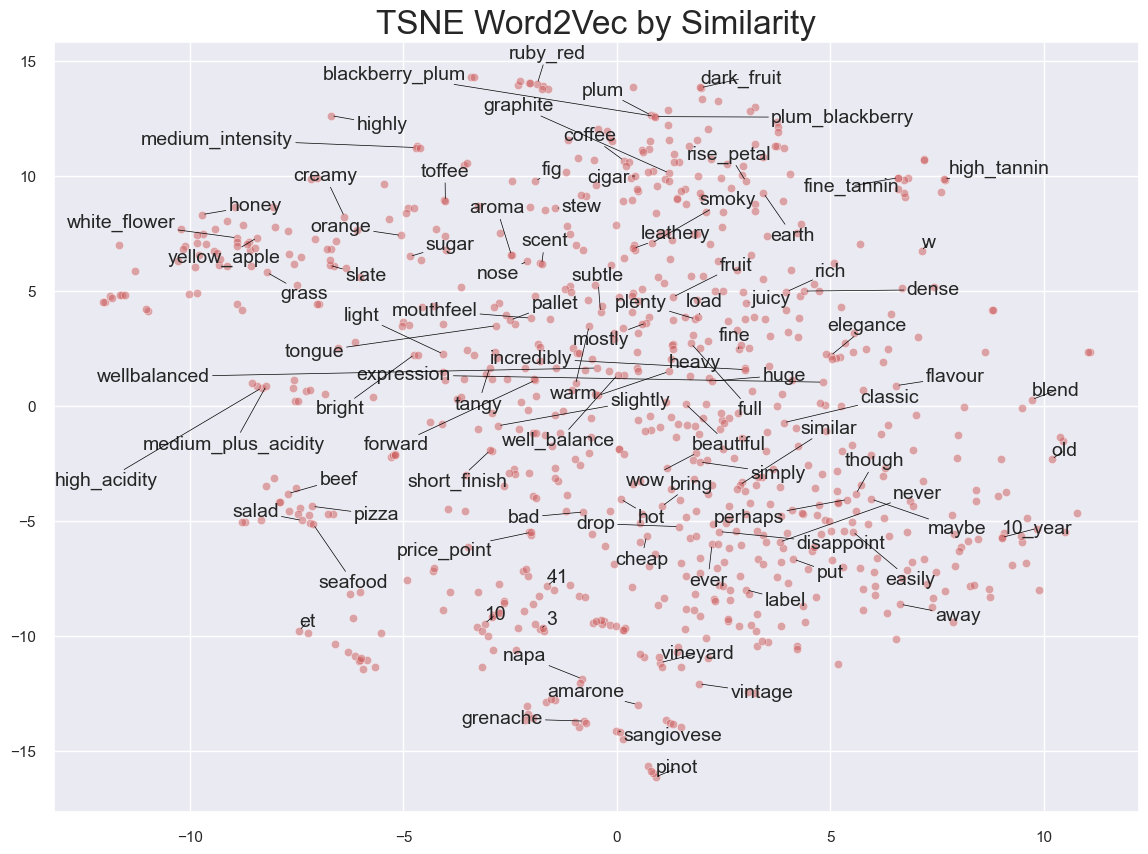

In [42]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(word_vec_df[:800])

sns.set()

plt.style.use('seaborn-deep')

# Initialize figure
fig, ax = plt.subplots(figsize = (14, 10))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5, color='indianred')

texts = []
words_to_plot = list(np.arange(0, 800, 8)) # every 8th word in first 800 words

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], 
                          tsne_df[word, 1], 
                          word_vec_df.index[word],
                          fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.title('TSNE Word2Vec by Similarity', fontsize=24)

plt.show()

In [43]:
asctime() 

'Sun Apr 30 04:47:10 2023'

In [44]:
#filter word_vec_def for the words output by word2vec_model.wv.most_similar(q2_tokens)?
word_vec_df_q2_tokens = pd.DataFrame()
for token in q2_tokens:
    d2_token_df_i = word_vec_df[word_vec_df.index==token]
    word_vec_df_q2_tokens = pd.concat([word_vec_df_q2_tokens, d2_token_df_i])
    
display(word_vec_df_q2_tokens)
    
vector_list_q2_tokens = word2vec_model.wv.get_mean_vector(word_vec_df_q2_tokens.index)

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(word_vec_df_q2_tokens)

0         1         2         3         4         5    \
term                                                                     
tonight    -0.087160 -0.323209 -0.402482  0.112780 -0.244200 -0.204681   
eat         0.332702 -0.131866 -0.540227 -0.076579 -0.516404 -0.447161   
pasta       0.909851  0.333862 -0.576991 -0.544191 -1.102771 -0.813735   
italian     0.326860  0.276389 -0.577807 -0.522993 -0.774893 -0.272299   
restaurant -0.380744 -0.342019 -1.093669  0.560175 -0.116129 -0.184338   
dinner     -0.337981 -0.003565 -1.155941 -0.045230 -0.918614 -0.545680   
nt          0.489598 -0.105637 -0.643766 -0.360779  0.276941 -0.078995   
like        0.147497  0.534542 -0.362431 -0.367926 -0.770698 -0.302008   
sweet       0.480342  0.452272 -0.235520 -1.197865 -0.895093  0.196660   
wine       -0.810270  0.648367 -0.154201  0.066380 -0.062330  0.540577   

                 6         7         8         9    ...       758       759  \
term                                                ...                       
tonight    -0.175529 -0.360138 -0.210339 -0.171723  ...  0.157401  0.401827   
eat        -0.015545 -0.409946 -0.204080 -0.009713  ...  0.241423  0.375118   
pasta      -0.222354 -1.143823 -0.387602  0.426180  ...  0.499578  0.091982   
italian    -0.005804 -0.589760 -0.389818  0.006081  ... -0.230651 -0.137258   
restaurant -0.345687 -0.391485 -0.301202  0.156658  ...  0.386667  0.440451   
dinner      0.200542 -0.743228 -0.346229 -0.083030  ...  0.196938  0.296986   
nt          0.757974 -0.457636  0.511426 -0.372299  ...  0.412506  0.774514   
like        0.633346 -0.544140  0.512444 -0.476653  ...  0.227510 -0.075593   
sweet       0.643870 -0.056106  0.220422 -0.915329  ... -1.053144 -0.502547   
wine        0.535287 -1.115164  0.253303 -0.865077  ... -0.401633 -0.334397   

                 760       761       762       763       764       765  \
term                                                                     
tonight    -0.153678  0.121038  0.043321  0.286542 -0.113613 -0.348465   
eat        -0.210353  0.320229  0.150262  0.140908 -0.112814 -0.007640   
pasta      -0.596812  0.843114 -0.263813  0.252007  0.116228 -0.415786   
italian    -0.620421  0.283899  0.244009  0.120986  0.090057 -0.359771   
restaurant  0.025182 -0.083294 -0.312113  0.766068  0.273359 -0.376210   
dinner      0.049408  0.022235 -0.308198  0.583603  0.232357 -0.501771   
nt         -1.074817  1.849232  0.817599 -0.346450 -1.014458 -0.238178   
like       -0.092634  0.279720  0.757433 -0.079827 -0.974173 -0.301848   
sweet      -0.115154  0.568018  0.017110  0.675807 -0.333221  0.354958   
wine       -0.457052 -0.495243  1.000720  0.499741  0.002692 -0.183328   

                 766       767  
term                            
tonight     0.210124 -0.302226  
eat         0.064025 -0.228770  
pasta      -0.654819 -0.425960  
italian     0.085288 -0.007463  
restaurant  0.031656 -0.767255  
dinner      0.058322 -0.084300  
nt          0.553372  0.258610  
like        0.889961  0.816179  
sweet       0.551347  1.482424  
wine        0.712401  0.103473  

[10 rows x 768 columns]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


# Plotting Questions With Word2Vec Most Similar Words

In [45]:
def word2vec_similarityPlot(q_tokens, question_nbr, TOPN=15):
    """
    Uses TSNE to plot based on Word2Vec score.
    """
    sns.set()
    plt.style.use('seaborn-deep')
    sns.set_palette("rocket") 

    #filter word_vec_def for the words output by word2vec_model.wv.most_similar(q2_tokens)?
    word_vec_df_q_tokens = pd.DataFrame()
    similar_words_df_q_tokens = pd.DataFrame()

    for token in q_tokens:
        q_token_df_i = word_vec_df[word_vec_df.index==token]
        word_vec_df_q_tokens = pd.concat([word_vec_df_q_tokens, q_token_df_i])
        similar_words_to_token = [idx[0] for idx in word2vec_model.wv.most_similar(positive=token, topn=TOPN)]
        for similar_token in similar_words_to_token:
            similar_token_df_j = word_vec_df[word_vec_df.index==similar_token]
            similar_words_df_q_tokens = pd.concat([similar_words_df_q_tokens, similar_token_df_j])

    vector_list_q1_tokens = word2vec_model.wv.get_mean_vector(word_vec_df_q_tokens.index)

    # Initialize t-SNE
    tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

    # Use only 400 rows to shorten processing time
    tsne_df = tsne.fit_transform(pd.concat([word_vec_df_q_tokens, similar_words_df_q_tokens]))

    # Initialize figure
    fig, ax = plt.subplots(figsize = (14, 12))
    sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

    texts = []
    words_to_plot = list(np.arange(0, len(word_vec_df_q_tokens), 1)) 

    # question tokens
    for word in words_to_plot:
        texts.append(plt.text(tsne_df[word, 0], 
                              tsne_df[word, 1], 
                              word_vec_df_q_tokens.index[word], 
                              color='maroon',
                              fontsize = 14))

    texts2 = []
    words_to_plot_q = list(np.arange(0, len(similar_words_df_q_tokens), 1)) 

    # question tokens' similar terms
    for word in words_to_plot_q:
        texts.append(plt.text(tsne_df[word, 0], 
                              tsne_df[word, 1], 
                              similar_words_df_q_tokens.index[word], 
                              fontsize = 14))

    # Plot text using adjust_text to prevent overlapping
    adjust_text(texts, force_points = 0.4, force_text = 0.4, 
                expand_points = (2, 1), expand_text = (1, 2),
                arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

    plt.title(f'Q{question_nbr} Tokens and Similar Terms by Word2Vec', fontsize = 24)
    plt.xlabel(f'{questions_df.question[int(question_nbr) - 1]}', fontsize=18)

    plt.show()

In [46]:
questions_df.question[int(1) - 1]

'I want to split a bottle of wine with my friends for a birthday. Were all most likely eating something different for dinner.'

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


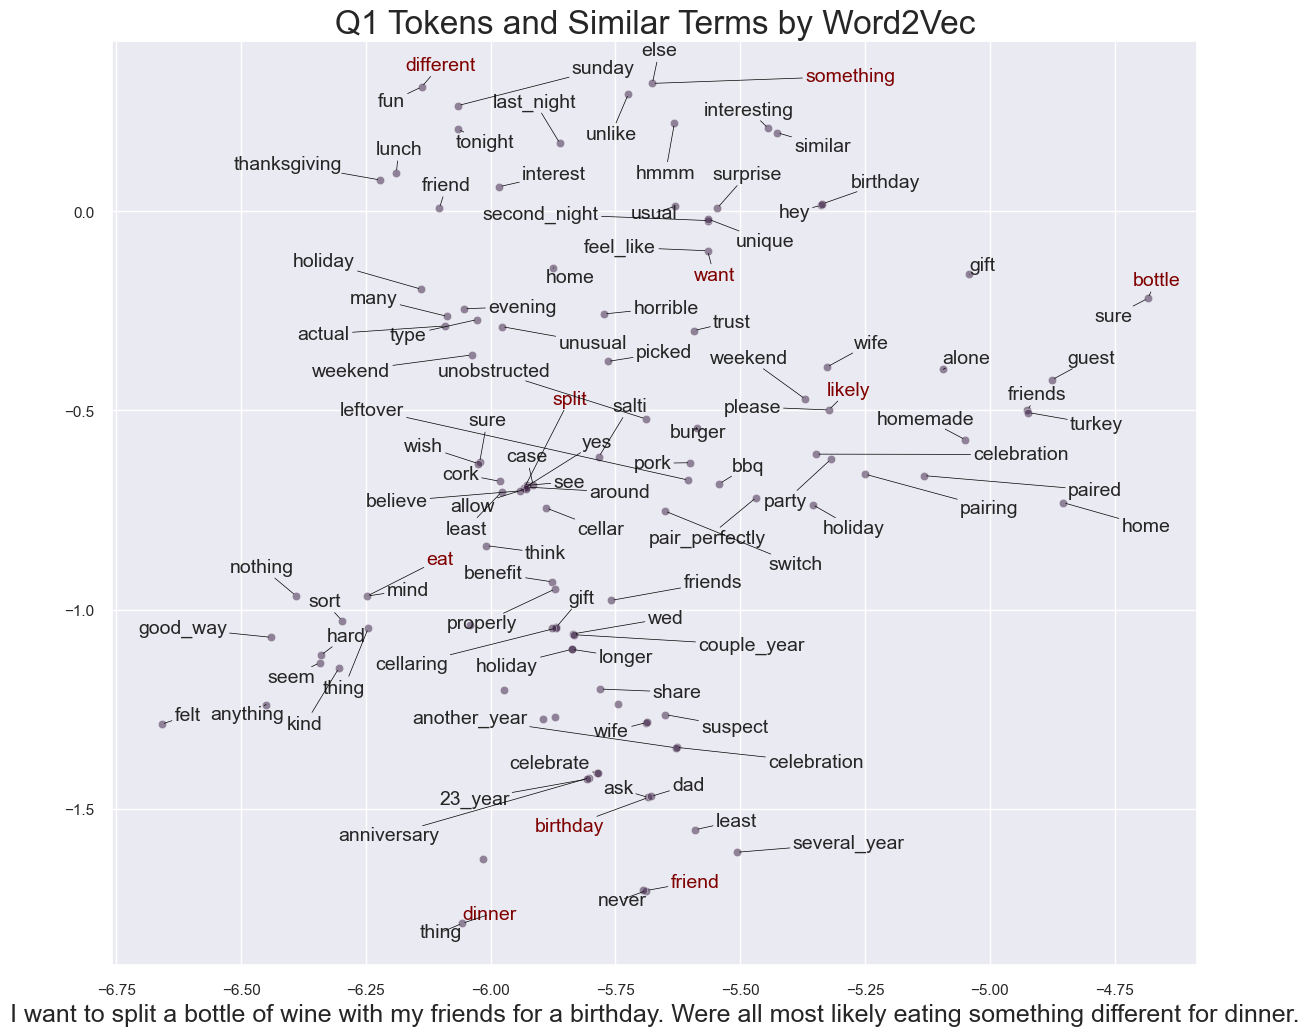

In [47]:
q1_tokens = questions_df.processed_question_tokens[0]
word2vec_similarityPlot(q1_tokens, '1', 10)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


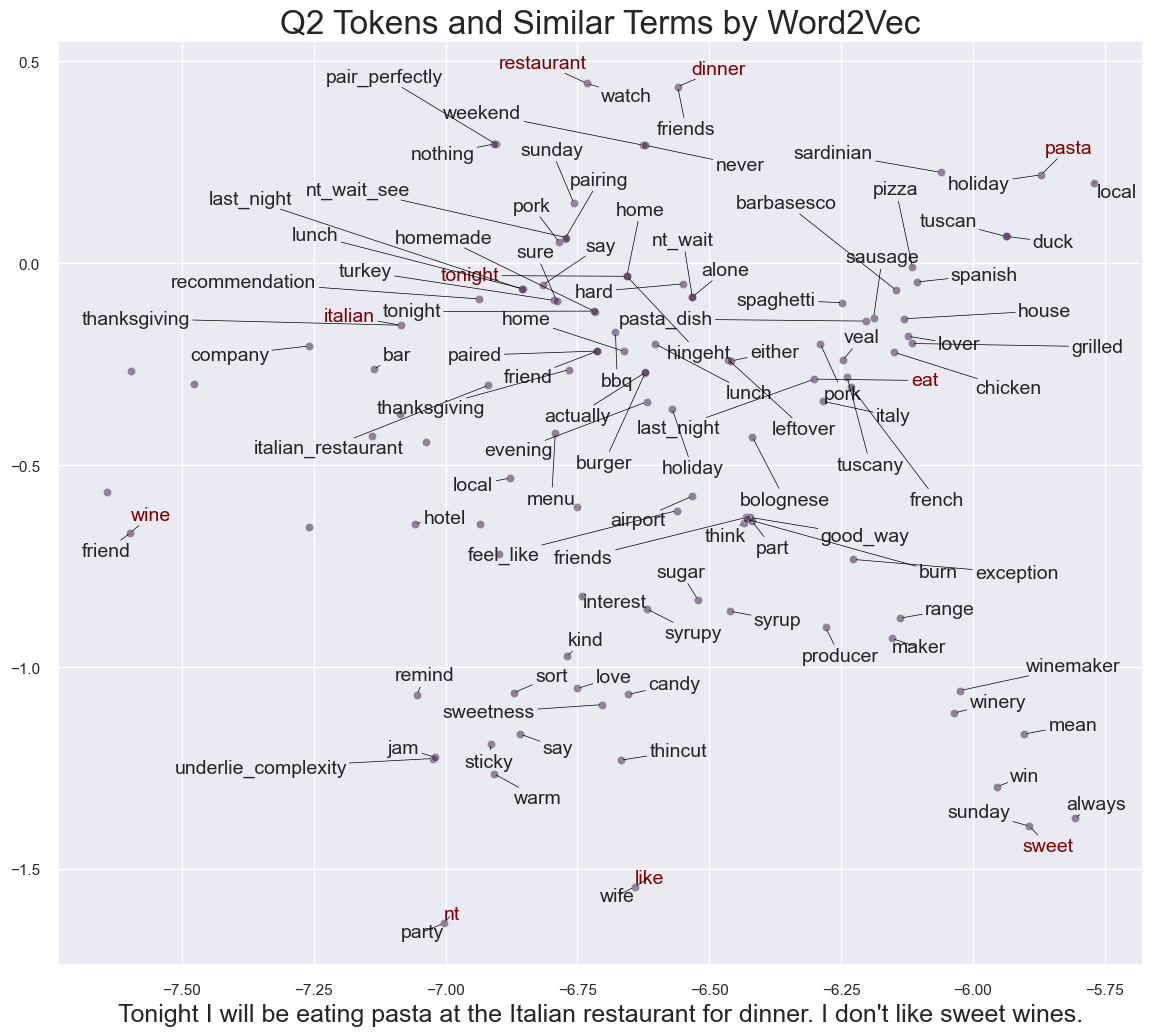

In [48]:
q2_tokens = questions_df.processed_question_tokens[1]
word2vec_similarityPlot(q2_tokens, '2', 10)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


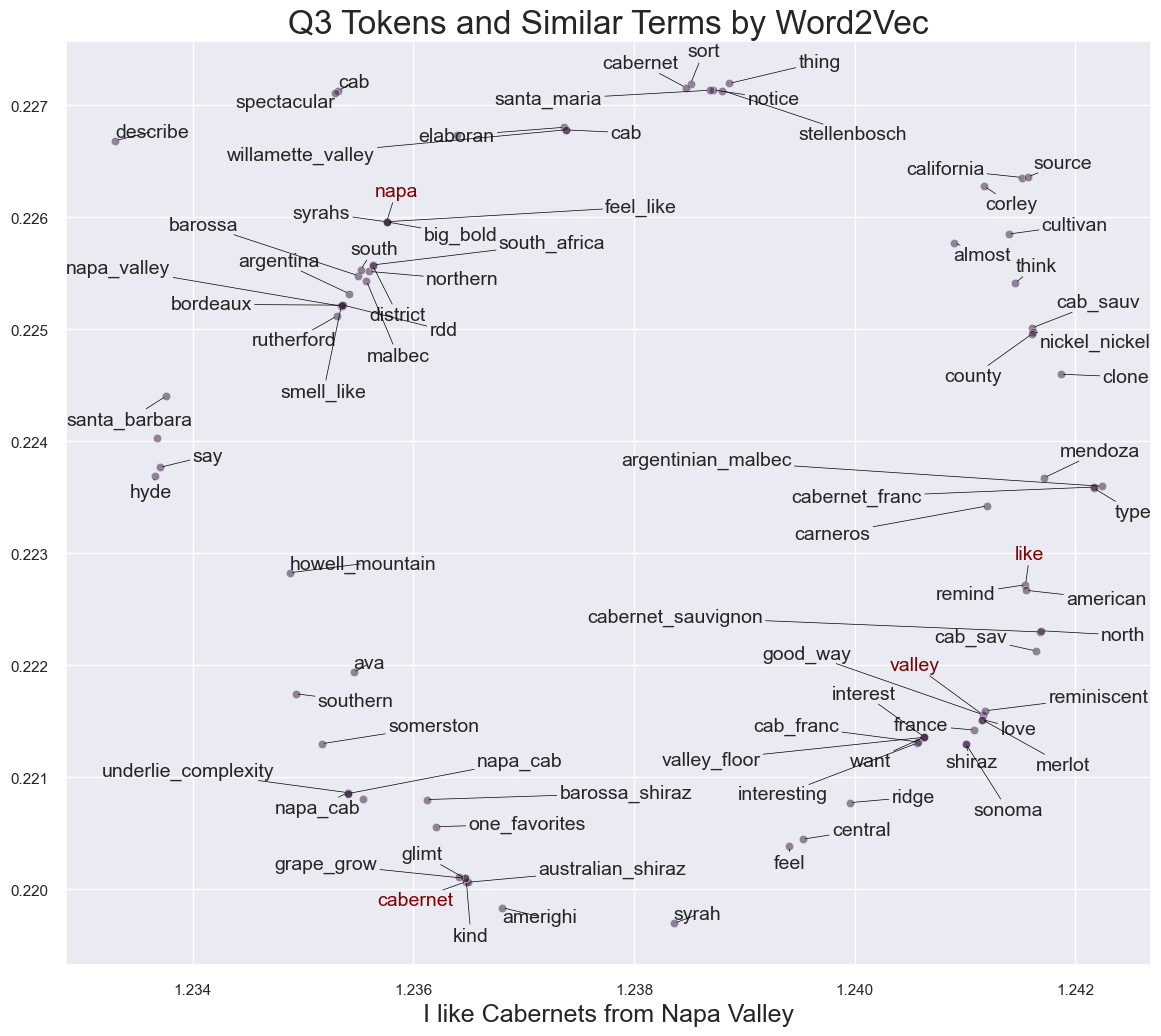

In [49]:
q3_tokens = questions_df.processed_question_tokens[2]
word2vec_similarityPlot(q3_tokens, '3', 20)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


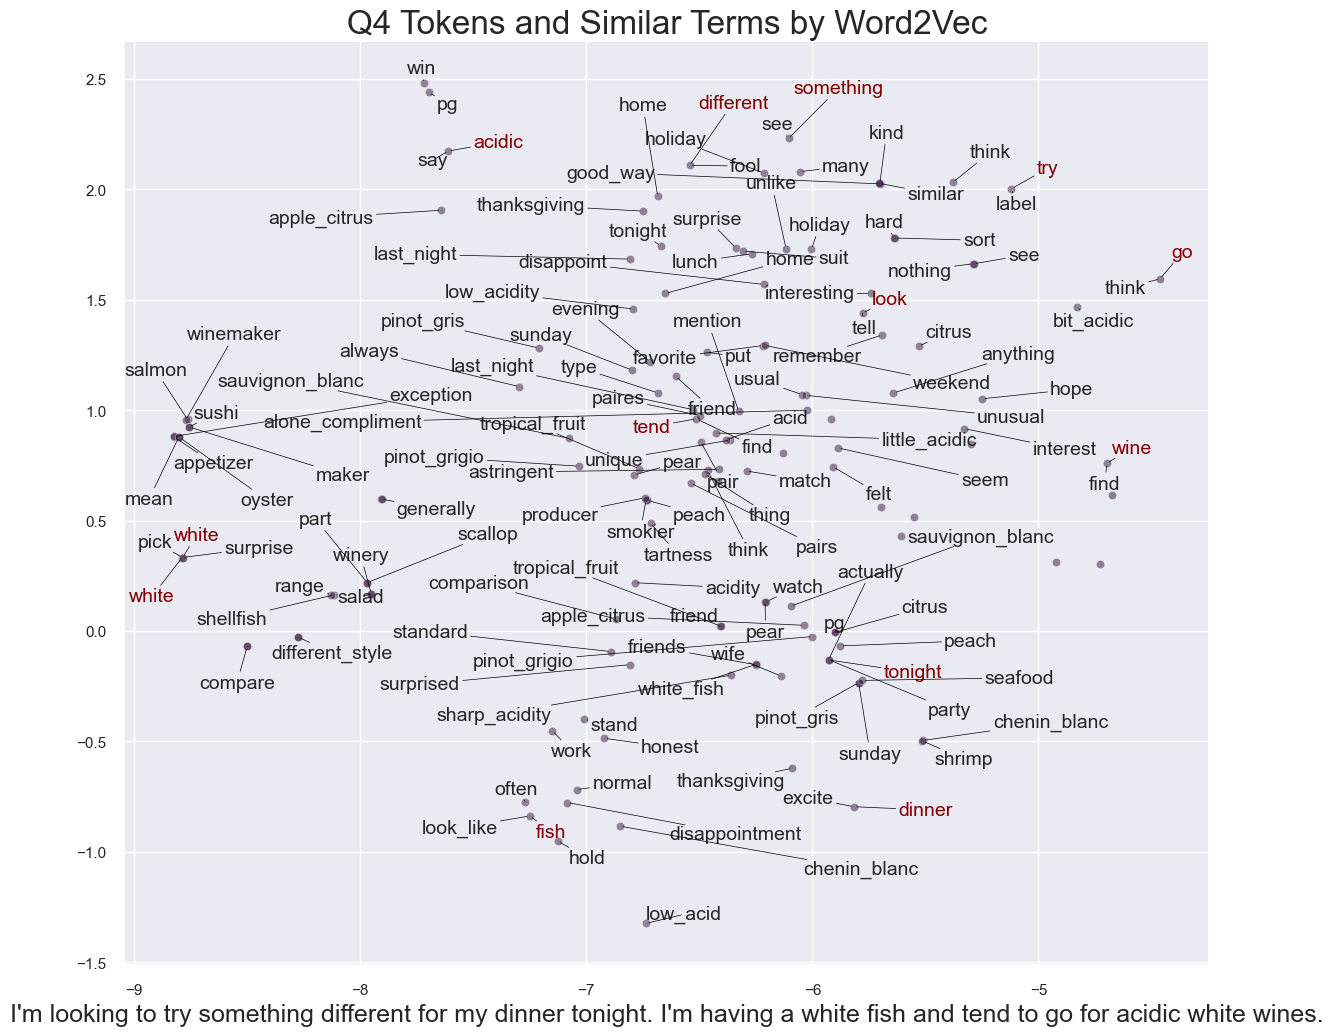

In [50]:
q4_tokens = questions_df.processed_question_tokens[3]
word2vec_similarityPlot(q4_tokens, '4', 10)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


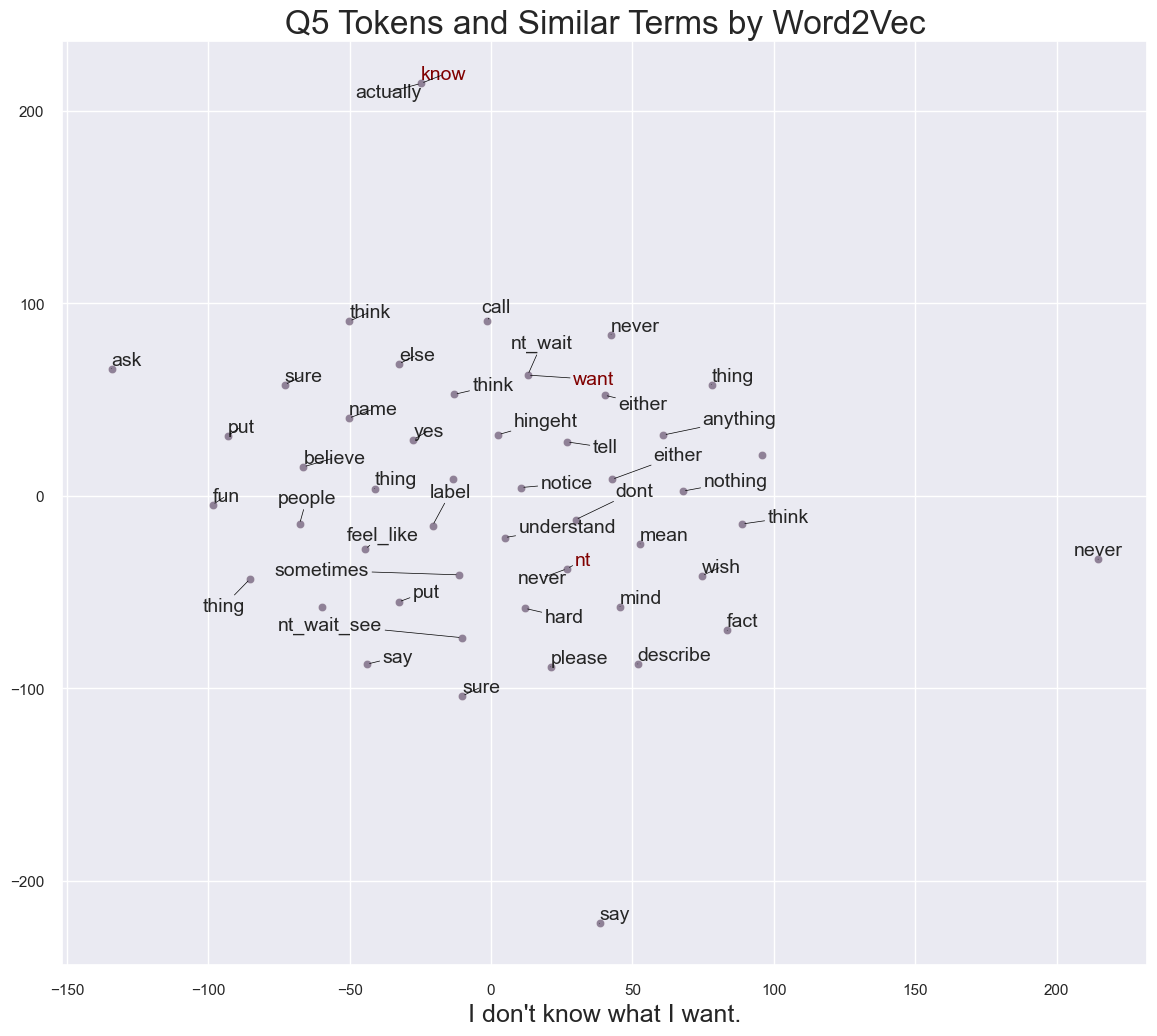

In [51]:
q5_tokens = questions_df.processed_question_tokens[4]
word2vec_similarityPlot(q5_tokens, '5', 15)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


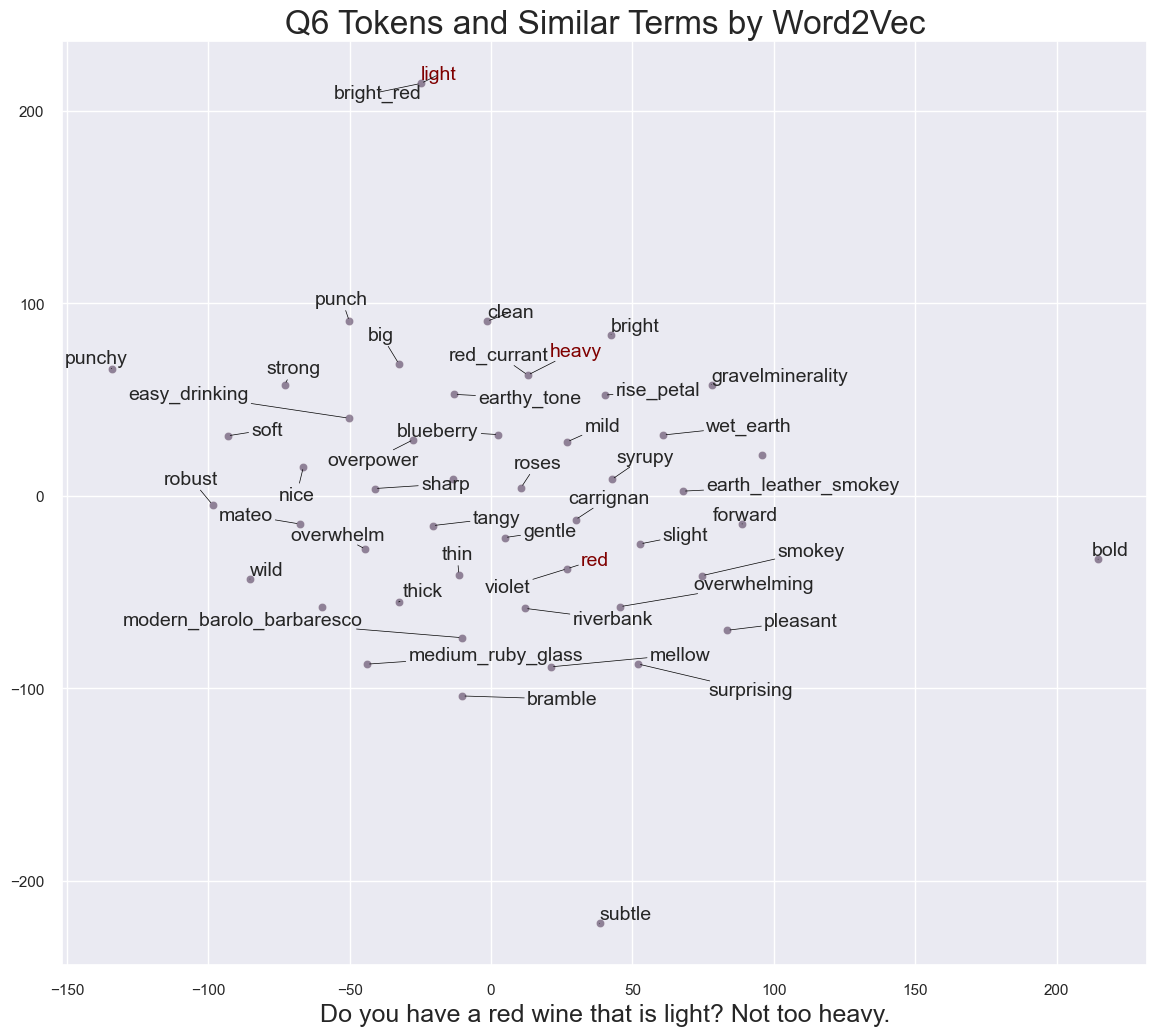

In [52]:
q6_tokens = questions_df.processed_question_tokens[5]
word2vec_similarityPlot(q6_tokens, '6', 15)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


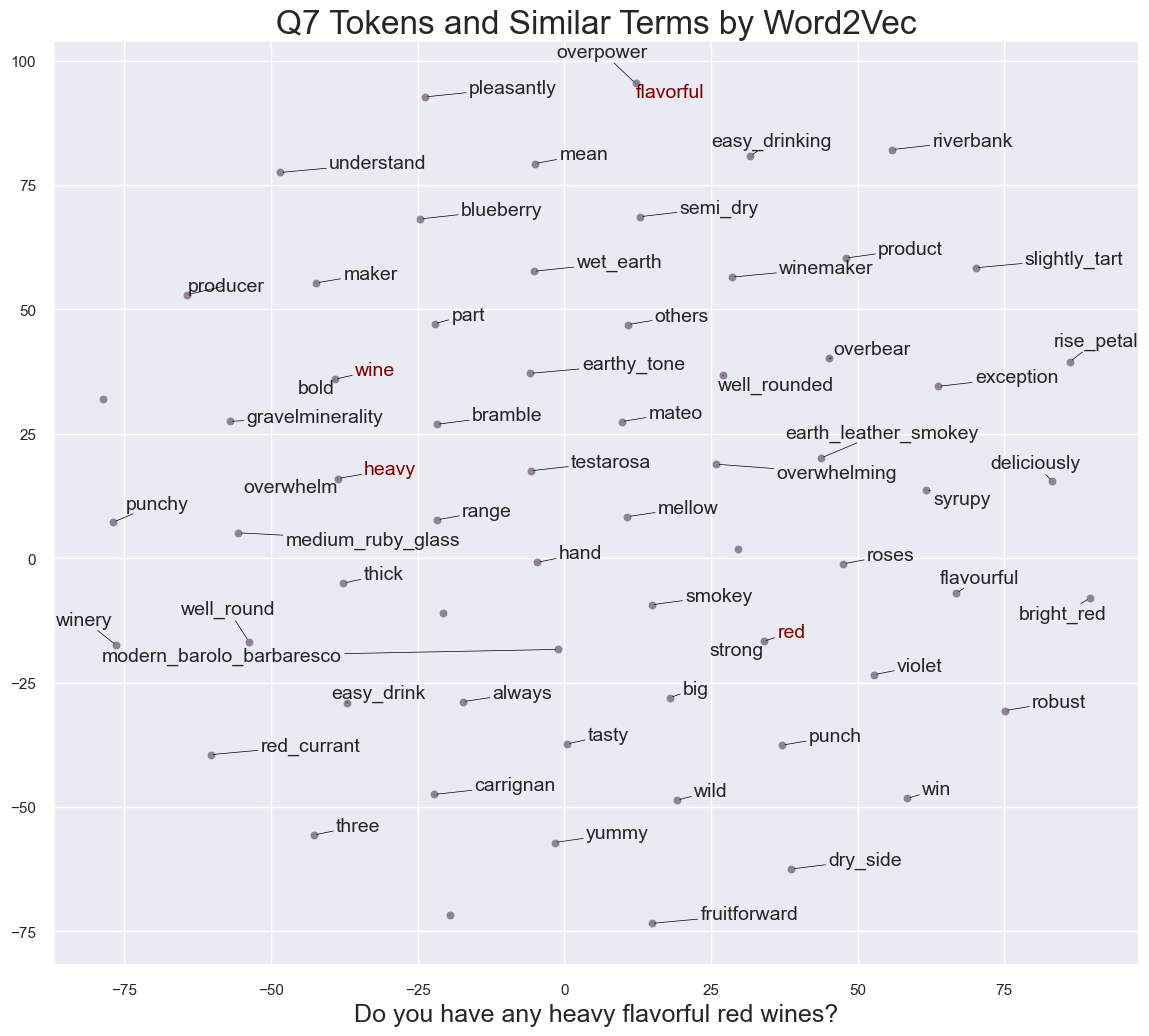

In [53]:
q7_tokens = questions_df.processed_question_tokens[6]
word2vec_similarityPlot(q7_tokens, '7', 15)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


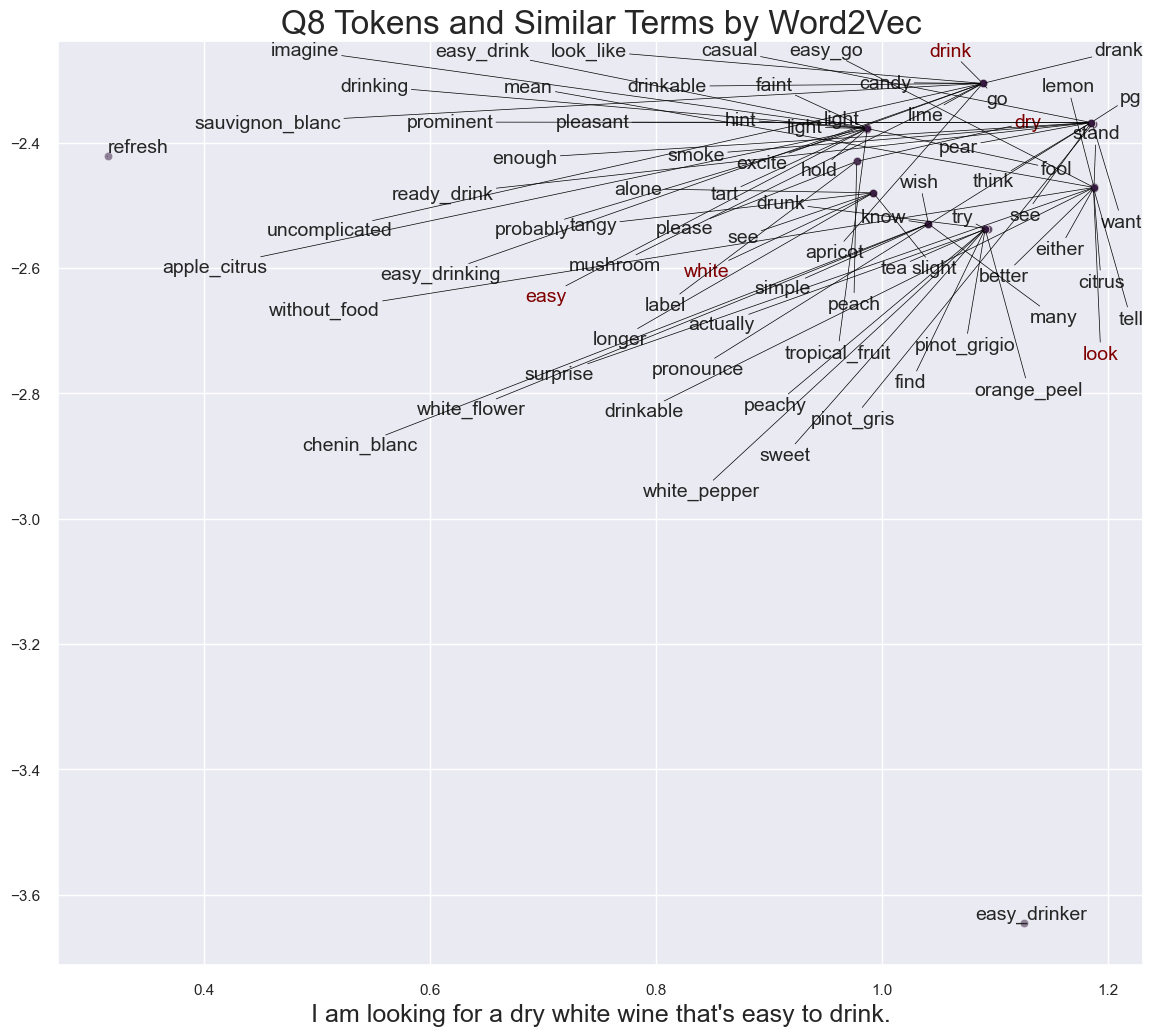

In [54]:
q8_tokens = questions_df.processed_question_tokens[7]
word2vec_similarityPlot(q8_tokens, '8', 15)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


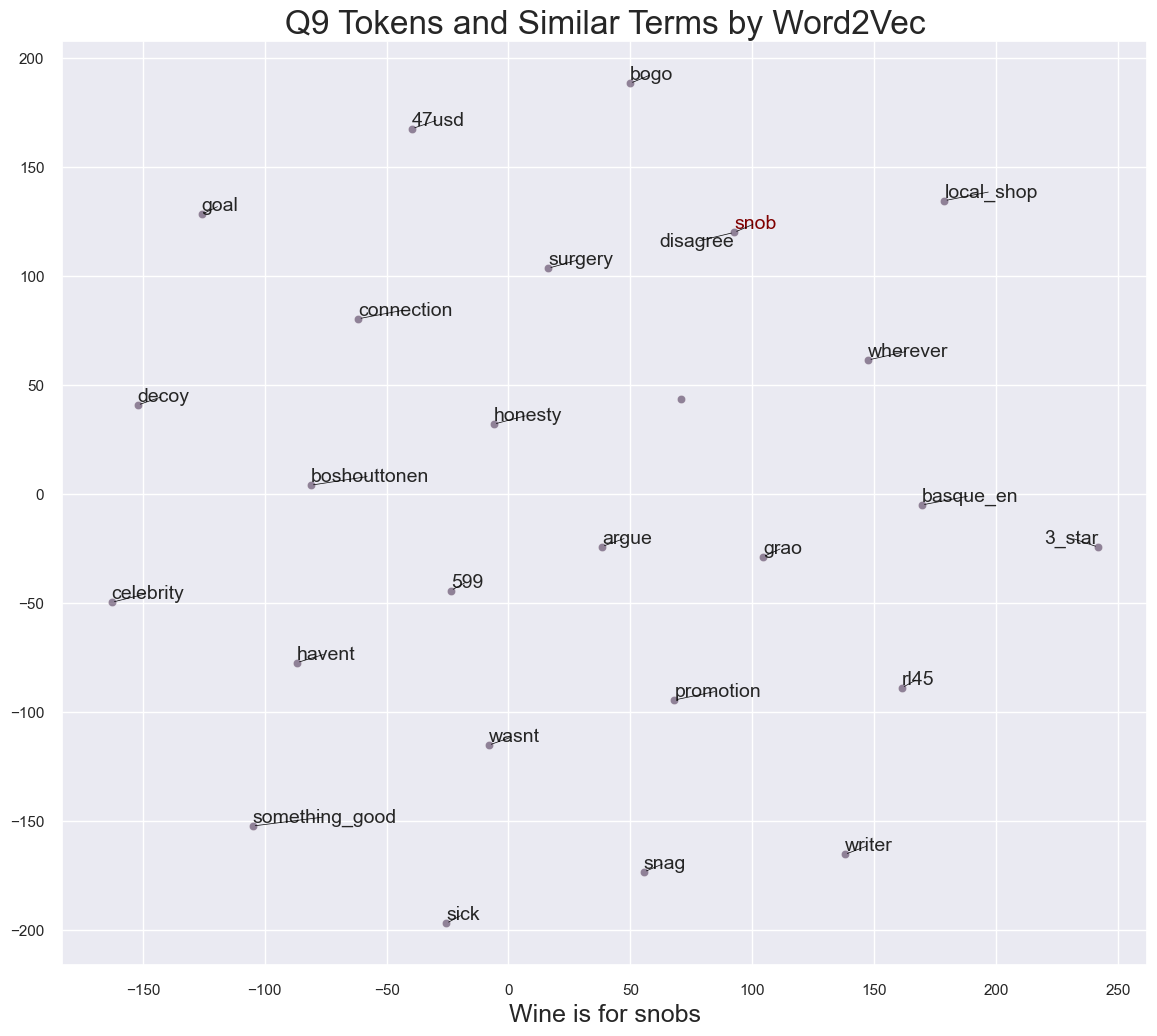

In [55]:
q9_tokens = questions_df.processed_question_tokens[8]
word2vec_similarityPlot(q9_tokens, '9', 25)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


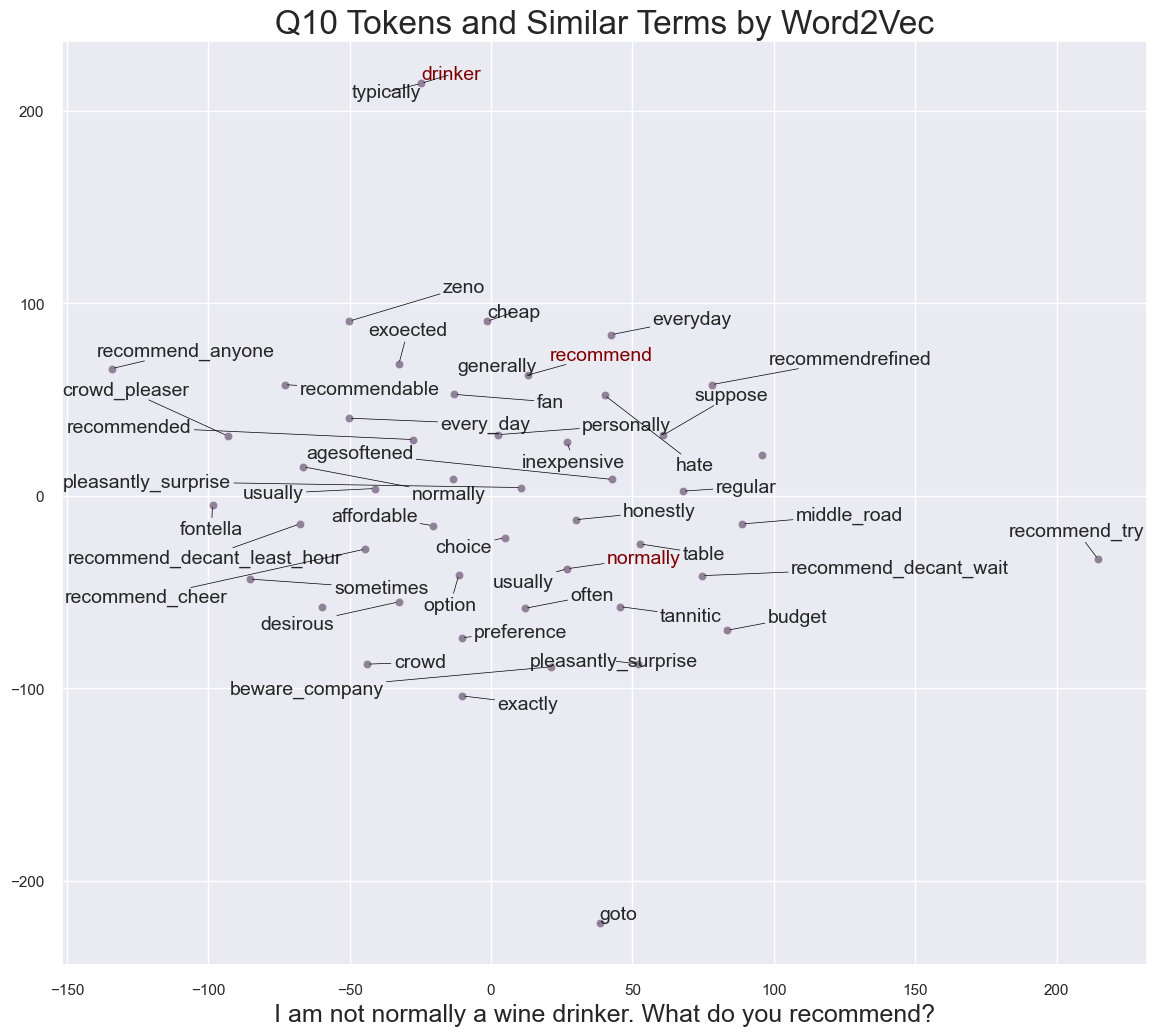

In [56]:
q10_tokens = questions_df.processed_question_tokens[9]
word2vec_similarityPlot(q10_tokens, '10', 15)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


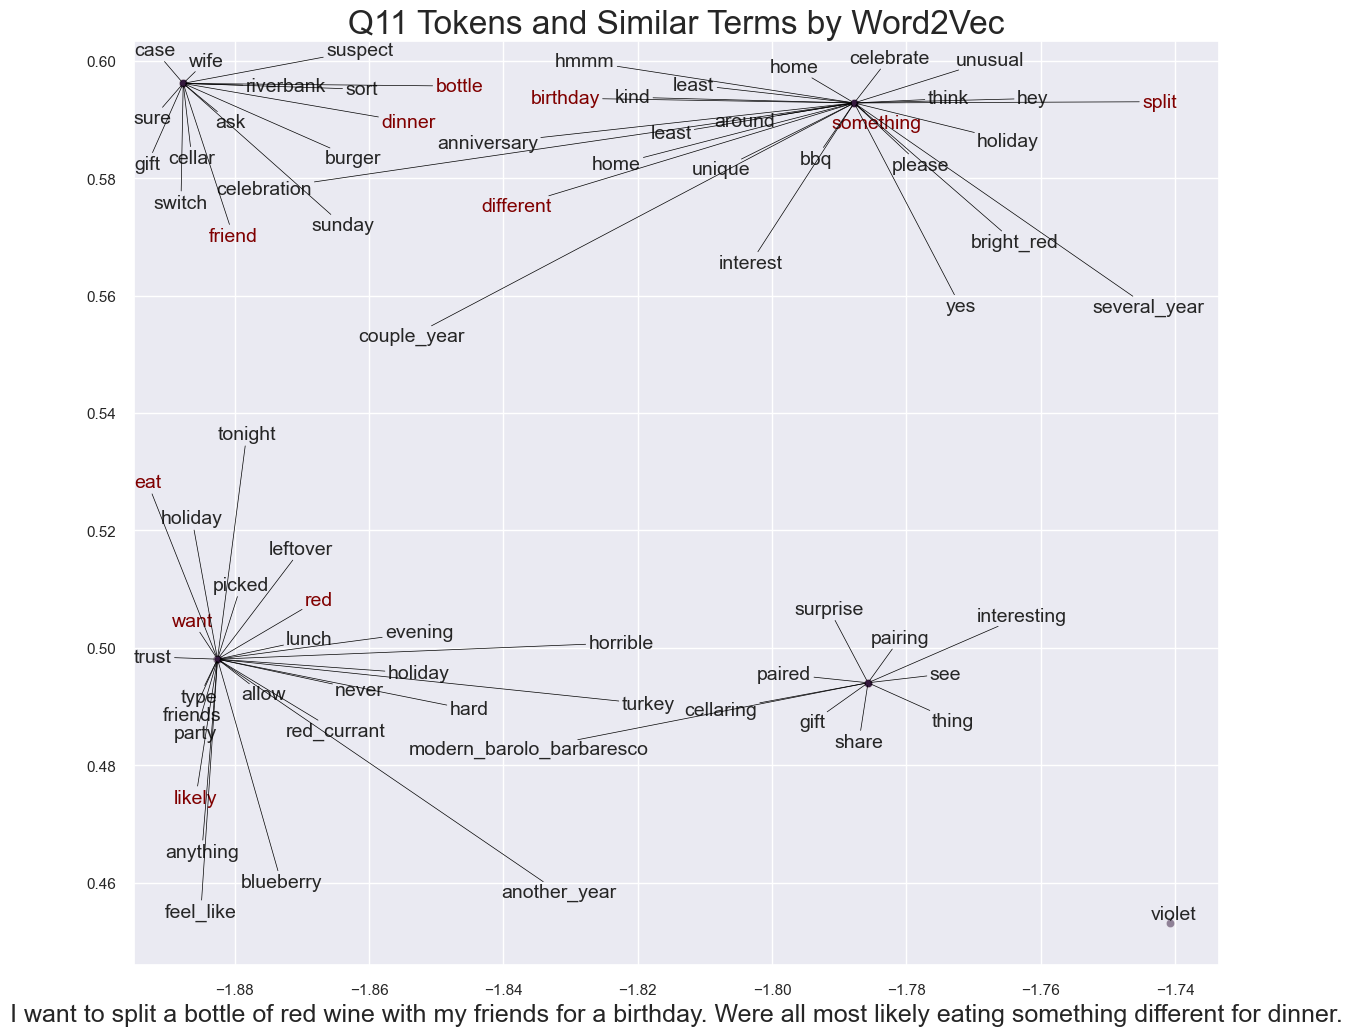

In [57]:
q11_tokens = questions_df.processed_question_tokens[10]
word2vec_similarityPlot(q11_tokens, '11', 6)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


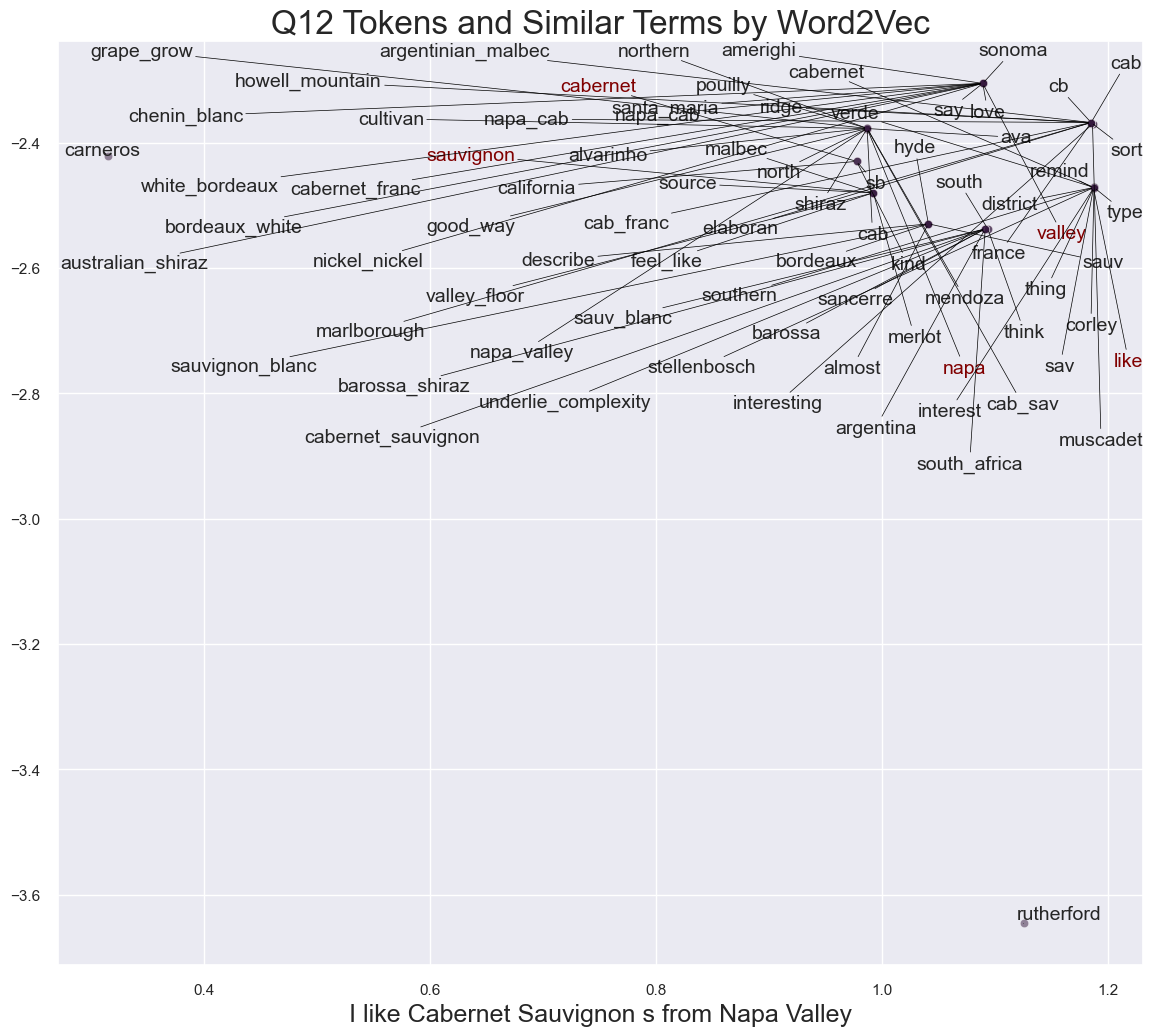

In [58]:
q12_tokens = questions_df.processed_question_tokens[11]
word2vec_similarityPlot(q12_tokens, '12', 15)

In [59]:
asctime()

'Sun Apr 30 04:58:13 2023'

In [60]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in word2vec_model.wv.index_to_key]
    try:
        mean_vector = word2vec_model.wv.get_mean_vector([word for word in doc if word in word2vec_model.wv.index_to_key])
    except Exception as exp:
        mean_vector = np.array([0.]*768, dtype='float32') # previously 300
    return mean_vector

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
#    doc = [word for word in doc if word not in stop_words]
    return doc

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.wv.index_to_key for word in doc)


# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc
    which takes a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)
    
    if texts is not None:
        for word in texts:
            if word not in word2vec_model.wv.index_to_key:
                while word in texts:
                    texts.remove(word)
        
        texts = [text for (text, doc) in zip(texts, corpus)]

    
    for doc in corpus:
        for word in doc:
            if word not in word2vec_model.wv.index_to_key:
                while word in doc:
                    doc.remove(word)
        
    print("complete.")

    return (corpus, texts)

In [65]:
df2 = pd.read_csv("../data/reduced_dimension_93Labels_dataset.csv")
df2['processed_text_tokens'] = df2['processed_text_tokens'].apply(eval)

In [66]:
combined_text = df2['processed_text_tokens'] #[0:100]
comb_text_list = [label for label in combined_text]
corpus = [label for label in combined_text]

In [71]:
asctime() 

'Sun Apr 30 05:55:14 2023'

In [72]:
corpus, comb_text_list = filter_docs(corpus, 
                                     comb_text_list,
                                     lambda doc: has_vector_representation(word2vec_model, doc))

complete.


In [73]:
len(corpus)

93

In [74]:
asctime()

'Sun Apr 30 08:24:31 2023'

In [75]:
corpus, comb_text_list = filter_docs(corpus, 
                                     comb_text_list,
                                     lambda doc: len(doc) > 0)

complete.


In [76]:
asctime()

'Sun Apr 30 09:01:15 2023'

In [77]:
x = []

for doc in corpus:
    x.append(document_vector(word2vec_model, doc))
    
X = np.array(x)

In [78]:
len(X)

93

In [79]:
asctime()

'Sun Apr 30 10:21:58 2023'

In [80]:
knn = NearestNeighbors(metric='cosine', 
                       algorithm='brute',
                       n_neighbors=5, 
                       n_jobs=-1)

knn.fit(X)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1)

In [81]:
asctime()

'Sun Apr 30 10:21:58 2023'

In [82]:
question_vecs = []
recommendations = {}
questions = questions_df.processed_question_str.values.tolist()

for idx, question in enumerate(questions): 
    question_text_list = question.split(" ")
    question_corpus = [preprocess(doc) for doc in question_text_list]
    question_corpus, question_text_list = filter_docs(question_corpus, 
                                         question_text_list,
                                         lambda doc: has_vector_representation(word2vec_model, doc))
    question_corpus, question_text_list = filter_docs(question_corpus, 
                                                      question_text_list, 
                                                      lambda doc: (len(doc) != 0))
    x2 = []
    for doc in question_corpus: 
        x2.append(document_vector(word2vec_model, doc))
        
    X2 = np.array(x2) 
    question_vecs.append(X2)
    distances, indices = knn.kneighbors(X2)
    recs = pd.DataFrame()
    for INDEX in range(len(indices)):
        df_distances = pd.DataFrame(distances[INDEX], columns=['cosine_distance_score'], index=indices[INDEX])
        df_wines = df2.iloc[indices[INDEX]]
        new_recs = df_distances.merge(df_wines, how='inner', left_index=True, right_index=True)
        recs = pd.concat([recs, new_recs])
    recommendations[questions_df.question.iloc[idx]] = recs

complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.


In [83]:
asctime()

'Sun Apr 30 10:21:59 2023'

In [84]:
len(distances)

3

In [90]:
interesting_columns = ['cosine_distance_score', 'label']

## Question 1

In [114]:
recommendations[questions_df.question.iloc[0]].sort_values("cosine_distance_score", ascending=False).head(7)[interesting_columns]

cosine_distance_score                             label
89               0.864178      Australia Cabernet Sauvignon
28               0.860247          Chile Cabernet Sauvignon
12               0.851454  United States Cabernet Sauvignon
75               0.850031              Australia Pinot Gris
63               0.839477               Italy Montepulciano
85               0.838469   South Africa Cabernet Sauvignon
63               0.834129               Italy Montepulciano

## Question 2

In [95]:
recommendations[questions_df.question.iloc[1]].sort_values("cosine_distance_score", ascending=False).head(7)[interesting_columns]

cosine_distance_score                             label
89               0.864178      Australia Cabernet Sauvignon
53               0.862272            Argentina Petit Verdot
12               0.851454  United States Cabernet Sauvignon
75               0.850031              Australia Pinot Gris
63               0.839477               Italy Montepulciano
85               0.838469   South Africa Cabernet Sauvignon
71               0.836724                    Italy Malvasia

## Question 3

In [96]:
recommendations[questions_df.question.iloc[2]].sort_values("cosine_distance_score", ascending=False).head(7)[interesting_columns]

cosine_distance_score                             label
8                0.761363      Argentina Cabernet Sauvignon
28               0.745445          Chile Cabernet Sauvignon
27               0.744482                  Argentina Merlot
53               0.742646            Argentina Petit Verdot
90               0.679442         Argentina Sauvignon Blanc
53               0.618146            Argentina Petit Verdot
12               0.617510  United States Cabernet Sauvignon

## Question 4

In [97]:
recommendations[questions_df.question.iloc[3]].sort_values("cosine_distance_score", ascending=False).head(7)[interesting_columns]

cosine_distance_score                             label
89               0.864178      Australia Cabernet Sauvignon
12               0.851454  United States Cabernet Sauvignon
75               0.850031              Australia Pinot Gris
63               0.839477               Italy Montepulciano
85               0.838469   South Africa Cabernet Sauvignon
75               0.835605              Australia Pinot Gris
12               0.823470  United States Cabernet Sauvignon

## Question 5

In [98]:
recommendations[questions_df.question.iloc[4]].sort_values("cosine_distance_score", ascending=False).head(7)[interesting_columns]

cosine_distance_score                         label
86               0.592498          New Zealand Riesling
89               0.589934  Australia Cabernet Sauvignon
75               0.588661          Australia Pinot Gris
38               0.577229      United States Pinot Gris
82               0.574953               France Grenache
89               0.572114  Australia Cabernet Sauvignon
77               0.571719            Australia Grenache

## Question 6

In [99]:
recommendations[questions_df.question.iloc[5]].sort_values("cosine_distance_score", ascending=False).head(7)[interesting_columns]

cosine_distance_score                    label
65               0.407043     Australia Pinot Noir
44               0.405400           Italy Grenache
49               0.405066         Italy Pinot Noir
22               0.392181   New Zealand Pinot Noir
55               0.387782  South Africa Pinot Noir
78               0.360283            Portugal Baga
70               0.360193    Argentina Tempranillo

## Question 7

In [100]:
recommendations[questions_df.question.iloc[6]].sort_values("cosine_distance_score", ascending=False).head(7)[interesting_columns]

cosine_distance_score                             label
78               0.668661                     Portugal Baga
29               0.661311          Italy Cabernet Sauvignon
12               0.657812  United States Cabernet Sauvignon
89               0.654361      Australia Cabernet Sauvignon
85               0.592068   South Africa Cabernet Sauvignon
11               0.457245          United States Chardonnay
75               0.456071              Australia Pinot Gris

## Question 8

In [101]:
recommendations[questions_df.question.iloc[7]].sort_values("cosine_distance_score", ascending=False).head(7)[interesting_columns]

cosine_distance_score                          label
38               0.524182       United States Pinot Gris
49               0.515358               Italy Pinot Noir
81               0.503190        South Africa Pinot Gris
75               0.480615           Australia Pinot Gris
77               0.462027             Australia Grenache
26               0.412768  United States Sauvignon Blanc
88               0.410269      Australia Sauvignon Blanc

## Question 9

In [102]:
recommendations[questions_df.question.iloc[8]].sort_values("cosine_distance_score", ascending=False).head(7)[interesting_columns]

cosine_distance_score                      label
67               0.444665         Germany Chardonnay
76               0.425551         Germany Pinot Gris
27               0.424570           Argentina Merlot
58               0.399259          Portugal Malvasia
90               0.352735  Argentina Sauvignon Blanc

## Question 10

In [103]:
recommendations[questions_df.question.iloc[9]].sort_values("cosine_distance_score", ascending=False).head(7)[interesting_columns]

cosine_distance_score                             label
70               0.743390             Argentina Tempranillo
12               0.742338  United States Cabernet Sauvignon
75               0.733160              Australia Pinot Gris
82               0.724463                   France Grenache
91               0.723024                 Canada Pinot Noir
71               0.611536                    Italy Malvasia
10               0.607934                Italy Pinot Grigio

## Question 11

In [104]:
recommendations[questions_df.question.iloc[10]].sort_values("cosine_distance_score", ascending=False).head(7)[interesting_columns]

cosine_distance_score                             label
89               0.864178      Australia Cabernet Sauvignon
28               0.860247          Chile Cabernet Sauvignon
12               0.851454  United States Cabernet Sauvignon
75               0.850031              Australia Pinot Gris
63               0.839477               Italy Montepulciano
85               0.838469   South Africa Cabernet Sauvignon
63               0.834129               Italy Montepulciano

# Question 12

In [107]:
recommendations[questions_df.question.iloc[11]].sort_values("cosine_distance_score", ascending=False).head(7)[interesting_columns]

cosine_distance_score                         label
8                0.761363  Argentina Cabernet Sauvignon
28               0.745445      Chile Cabernet Sauvignon
27               0.744482              Argentina Merlot
53               0.742646        Argentina Petit Verdot
90               0.679442     Argentina Sauvignon Blanc
50               0.671048      Argentina Cabernet Franc
28               0.624645      Chile Cabernet Sauvignon

# Raw cosine similarity

In [121]:
question_vecs = []
recommendations = {}
questions = questions_df.processed_question_str.values.tolist()

for idx, question in enumerate(questions): 
    question_text_list = question.split(" ")
    question_corpus = [preprocess(doc) for doc in question_text_list]
    question_corpus, question_text_list = filter_docs(question_corpus, 
                                         question_text_list,
                                         lambda doc: has_vector_representation(word2vec_model, doc))
    question_corpus, question_text_list = filter_docs(question_corpus, 
                                                      question_text_list, 
                                                      lambda doc: (len(doc) != 0))
    x2 = []
    for doc in question_corpus: 
        x2.append(document_vector(word2vec_model, doc))
        
    X2 = np.array(x2) 
    question_vecs.append(X2)

complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.
complete.


In [137]:
cosine_similarity(X[0].reshape(1, -1), question_vecs[0]).mean()

0.18927602

## Question 1

In [146]:
df2['q1_cosim'] = ''
for idx in range(0, df2.shape[0]):
    df2.loc[idx, 'q1_cosim'] = cosine_similarity(X[idx].reshape(1, -1), question_vecs[0]).mean()
df2.sort_values('q1_cosim', ascending=False).head(5)[['label', 'q1_cosim']]

label  q1_cosim
63              Italy Montepulciano  0.287277
75             Australia Pinot Gris  0.285306
85  South Africa Cabernet Sauvignon  0.275025
89     Australia Cabernet Sauvignon  0.270009
87                Portugal Aragonez  0.267816

## Question 2

In [148]:
df2['q2_cosim'] = ''
for idx in range(0, df2.shape[0]):
    df2.loc[idx, 'q2_cosim'] = cosine_similarity(X[idx].reshape(1, -1), question_vecs[1]).mean()
df2.sort_values('q2_cosim', ascending=False).head(5)[['label', 'q2_cosim']]

label  q2_cosim
75      Australia Pinot Gris  0.297248
77        Australia Grenache  0.284505
38  United States Pinot Gris  0.275908
91         Canada Pinot Noir  0.274063
82           France Grenache  0.271314

## Question 3

In [150]:
df2['q3_cosim'] = ''
for idx in range(0, df2.shape[0]):
    df2.loc[idx, 'q3_cosim'] = cosine_similarity(X[idx].reshape(1, -1), question_vecs[2]).mean()
df2.sort_values('q3_cosim', ascending=False).head(5)[['label', 'q3_cosim']]

label  q3_cosim
85   South Africa Cabernet Sauvignon  0.366292
89      Australia Cabernet Sauvignon  0.344708
12  United States Cabernet Sauvignon   0.34064
8       Argentina Cabernet Sauvignon  0.333398
70             Argentina Tempranillo  0.326701

## Question 4

In [157]:
IDX = 4
df2[f'q{IDX}_cosim'] = ''
for idx in range(0, df2.shape[0]):
    df2.loc[idx, f'q{IDX}_cosim'] = cosine_similarity(X[idx].reshape(1, -1), question_vecs[(IDX-1)]).mean()
df2.sort_values(f'q{IDX}_cosim', ascending=False).head(5)[['label', f'q{IDX}_cosim']]

label  q4_cosim
75      Australia Pinot Gris  0.346718
71            Italy Malvasia  0.327267
38  United States Pinot Gris  0.318656
57      Argentina Pinot Gris   0.31414
77        Australia Grenache  0.313884

## Question 5

In [158]:
IDX = 5
df2[f'q{IDX}_cosim'] = ''
for idx in range(0, df2.shape[0]):
    df2.loc[idx, f'q{IDX}_cosim'] = cosine_similarity(X[idx].reshape(1, -1), question_vecs[(IDX-1)]).mean()
df2.sort_values(f'q{IDX}_cosim', ascending=False).head(5)[['label', f'q{IDX}_cosim']]

label  q5_cosim
75             Australia Pinot Gris  0.481313
77               Australia Grenache  0.470142
85  South Africa Cabernet Sauvignon  0.456667
89     Australia Cabernet Sauvignon  0.448084
38         United States Pinot Gris   0.44095

## Question 6

In [159]:
IDX = 6
df2[f'q{IDX}_cosim'] = ''
for idx in range(0, df2.shape[0]):
    df2.loc[idx, f'q{IDX}_cosim'] = cosine_similarity(X[idx].reshape(1, -1), question_vecs[(IDX-1)]).mean()
df2.sort_values(f'q{IDX}_cosim', ascending=False).head(5)[['label', f'q{IDX}_cosim']]

label  q6_cosim
91         Canada Pinot Noir  0.646285
82           France Grenache  0.645087
55   South Africa Pinot Noir  0.634015
22    New Zealand Pinot Noir  0.632254
25  United States Pinot Noir  0.629304

## Question 7

In [160]:
IDX = 7
df2[f'q{IDX}_cosim'] = ''
for idx in range(0, df2.shape[0]):
    df2.loc[idx, f'q{IDX}_cosim'] = cosine_similarity(X[idx].reshape(1, -1), question_vecs[(IDX-1)]).mean()
df2.sort_values(f'q{IDX}_cosim', ascending=False).head(5)[['label', f'q{IDX}_cosim']]

label  q7_cosim
82           France Grenache  0.515615
78             Portugal Baga  0.513998
25  United States Pinot Noir  0.509645
70     Argentina Tempranillo  0.508038
91         Canada Pinot Noir  0.498718

## Question 8

In [161]:
IDX = 8
df2[f'q{IDX}_cosim'] = ''
for idx in range(0, df2.shape[0]):
    df2.loc[idx, f'q{IDX}_cosim'] = cosine_similarity(X[idx].reshape(1, -1), question_vecs[(IDX-1)]).mean()
df2.sort_values(f'q{IDX}_cosim', ascending=False).head(5)[['label', f'q{IDX}_cosim']]

label  q8_cosim
81    South Africa Pinot Gris  0.571738
75       Australia Pinot Gris  0.570435
38   United States Pinot Gris  0.562222
88  Australia Sauvignon Blanc  0.552363
61     New Zealand Pinot Gris  0.549227

## Question 9

In [162]:
IDX = 9
df2[f'q{IDX}_cosim'] = ''
for idx in range(0, df2.shape[0]):
    df2.loc[idx, f'q{IDX}_cosim'] = cosine_similarity(X[idx].reshape(1, -1), question_vecs[(IDX-1)]).mean()
df2.sort_values(f'q{IDX}_cosim', ascending=False).head(5)[['label', f'q{IDX}_cosim']]

label  q9_cosim
90  Argentina Sauvignon Blanc  0.647265
58          Portugal Malvasia  0.600741
27           Argentina Merlot   0.57543
76         Germany Pinot Gris  0.574449
67         Germany Chardonnay  0.555335

## Question 10

In [163]:
IDX = 10
df2[f'q{IDX}_cosim'] = ''
for idx in range(0, df2.shape[0]):
    df2.loc[idx, f'q{IDX}_cosim'] = cosine_similarity(X[idx].reshape(1, -1), question_vecs[(IDX-1)]).mean()
df2.sort_values(f'q{IDX}_cosim', ascending=False).head(5)[['label', f'q{IDX}_cosim']]

label q10_cosim
75           Australia Pinot Gris   0.39677
38       United States Pinot Gris  0.358962
71                 Italy Malvasia  0.333904
26  United States Sauvignon Blanc  0.333151
33    New Zealand Sauvignon Blanc   0.33074

## Question 11

In [164]:
IDX = 11
df2[f'q{IDX}_cosim'] = ''
for idx in range(0, df2.shape[0]):
    df2.loc[idx, f'q{IDX}_cosim'] = cosine_similarity(X[idx].reshape(1, -1), question_vecs[(IDX-1)]).mean()
df2.sort_values(f'q{IDX}_cosim', ascending=False).head(5)[['label', f'q{IDX}_cosim']]

label q11_cosim
63              Italy Montepulciano  0.303621
85  South Africa Cabernet Sauvignon   0.29884
89     Australia Cabernet Sauvignon  0.292152
75             Australia Pinot Gris  0.287549
77               Australia Grenache  0.284852

## Question 12

In [165]:
IDX = 12
df2[f'q{IDX}_cosim'] = ''
for idx in range(0, df2.shape[0]):
    df2.loc[idx, f'q{IDX}_cosim'] = cosine_similarity(X[idx].reshape(1, -1), question_vecs[(IDX-1)]).mean()
df2.sort_values(f'q{IDX}_cosim', ascending=False).head(5)[['label', f'q{IDX}_cosim']]

label q12_cosim
8      Argentina Cabernet Sauvignon  0.331173
85  South Africa Cabernet Sauvignon  0.330712
28         Chile Cabernet Sauvignon   0.32089
53           Argentina Petit Verdot  0.309382
89     Australia Cabernet Sauvignon  0.304777

# More Visualizations

In [177]:
wines_list = df['Full_Vintage_Name'].values.tolist()

In [178]:
len(wines_list)

255797

In [179]:
asctime()

'Sun Apr 30 12:01:45 2023'

In [180]:
combined_text = df['processed_text_tokens'][0:1000]
comb_text_list = [label for label in combined_text]
corpus = [label for label in combined_text]

corpus, comb_text_list = filter_docs(corpus, 
                                     comb_text_list,
                                     lambda doc: has_vector_representation(word2vec_model, doc))

corpus, comb_text_list = filter_docs(corpus, 
                                     comb_text_list,
                                     lambda doc: len(doc) > 0)

x = []

for doc in corpus:
    x.append(document_vector(word2vec_model, doc))
    
X = np.array(x)

complete.
complete.


In [203]:
vintage_list = df[df['Single_Most_Used_Grape']=='Cabernet Sauvignon']['Vintage_Year'].values.tolist()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


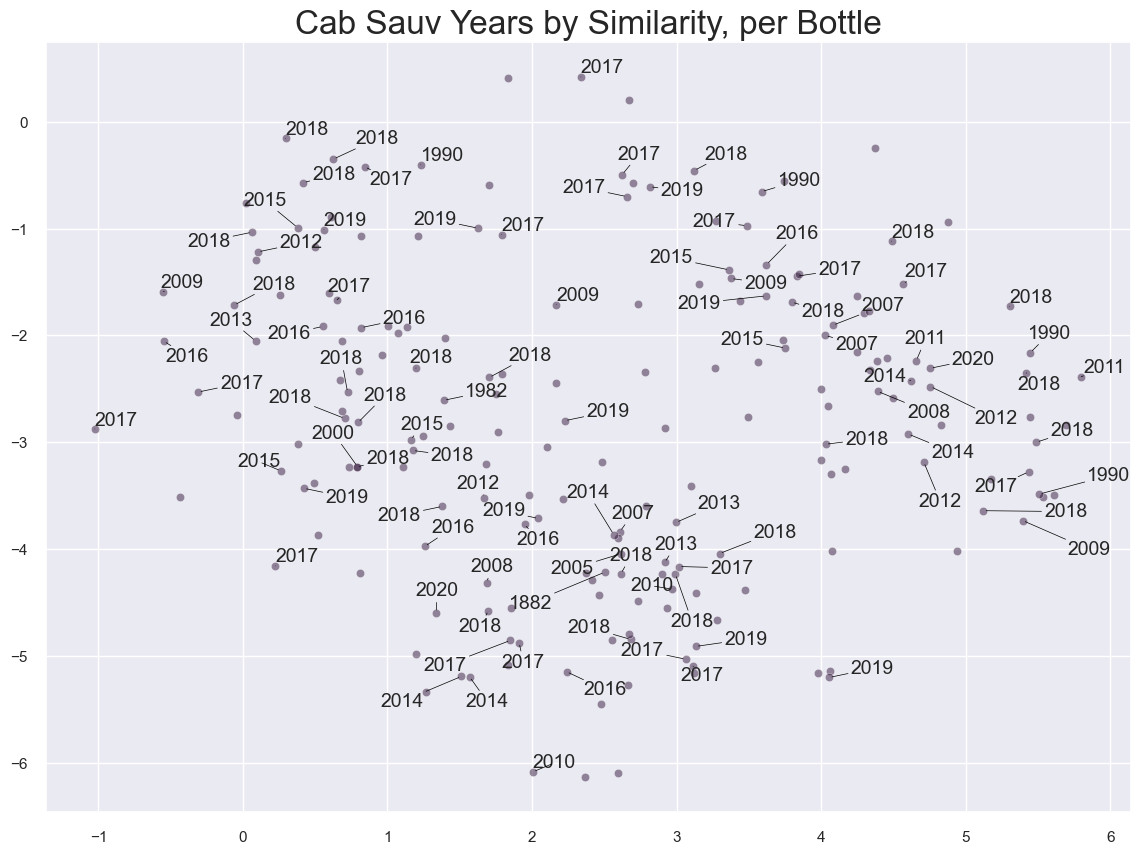

In [205]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# 100 rows to shorten processing time
tsne_df = tsne.fit_transform(X[:200])
fig, ax = plt.subplots(figsize = (14, 10))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

texts = []
years_to_plot = list(np.arange(0, 200, 2)) # plots every 2nd title in first 200 titles

# Append words to list
for year in years_to_plot:
    texts.append(plt.text(tsne_df[year, 0], tsne_df[year, 1], vintage_list[year], fontsize = 14))
    
# Plot text using adjust_text
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.title("Cab Sauv Years by Similarity, per Bottle", fontsize=24)
plt.show()

In [181]:
asctime()

'Sun Apr 30 12:02:57 2023'

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


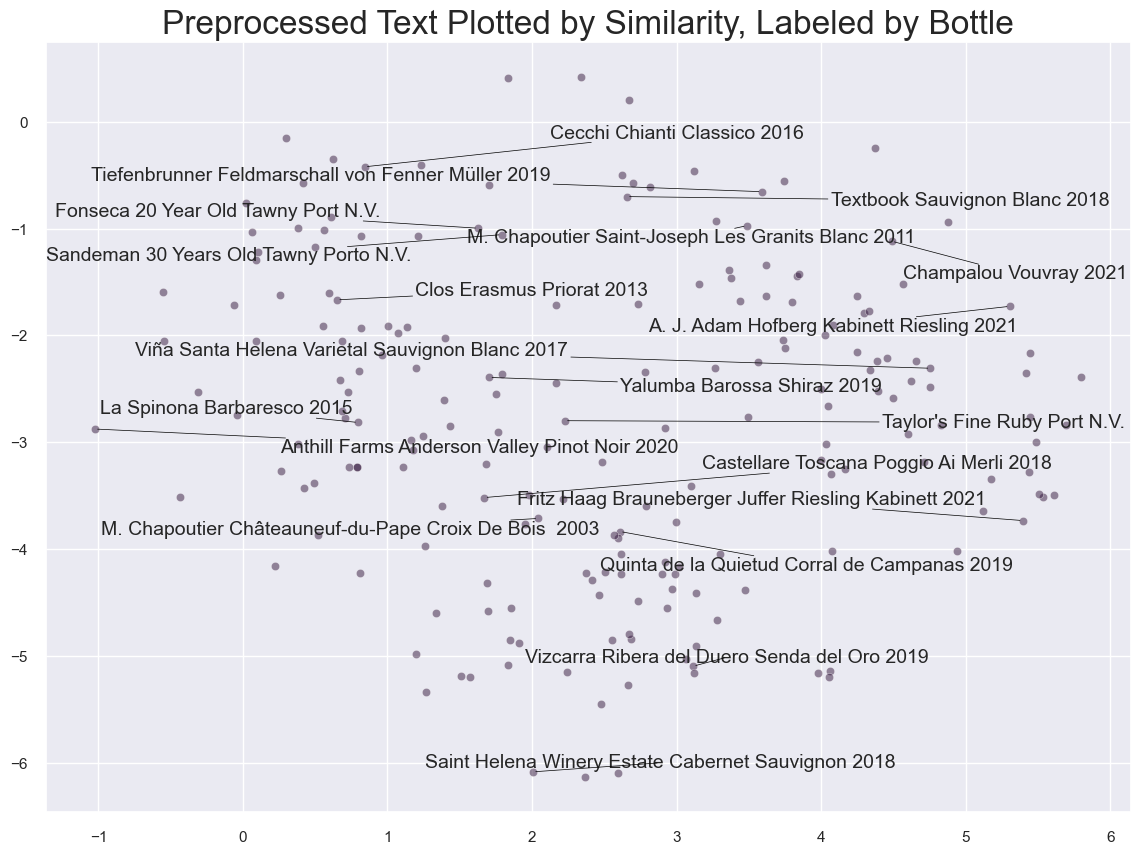

In [194]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# 100 rows to shorten processing time
tsne_df = tsne.fit_transform(X[:200])
fig, ax = plt.subplots(figsize = (14, 10))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

texts = []
wines_to_plot = list(np.arange(0, 200, 10)) # plots every 10th title in first 200 titles

# Append words to list
for wine in wines_to_plot:
    texts.append(plt.text(tsne_df[wine, 0], tsne_df[wine, 1], wines_list[wine], fontsize = 14))
    
# Plot text using adjust_text
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.title("Preprocessed Text Plotted by Similarity, Labeled by Bottle", fontsize=24)
plt.show()

In [184]:
asctime()

'Sun Apr 30 12:09:19 2023'

In [185]:
label_list = df['Label'].values.tolist()

In [186]:
len(label_list)

255797

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


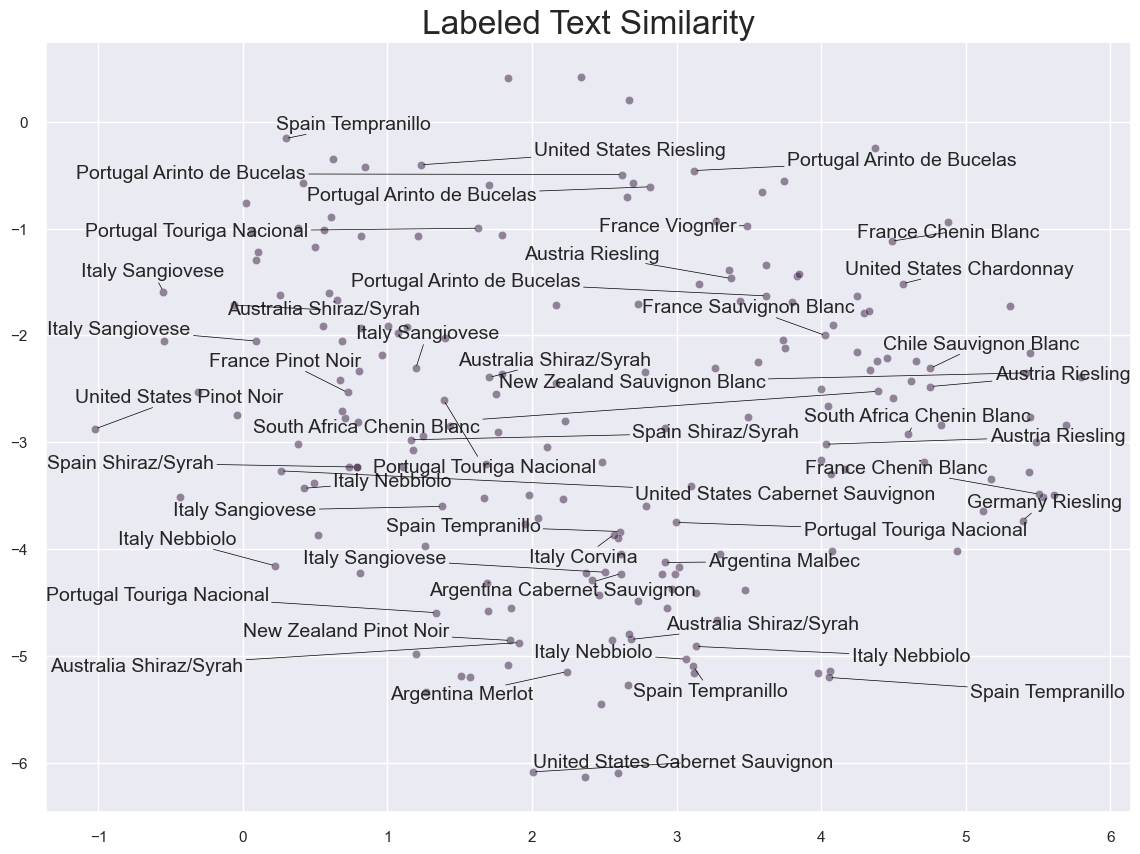

In [206]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# 100 rows to shorten processing time
tsne_df = tsne.fit_transform(X[:200])
fig, ax = plt.subplots(figsize = (14, 10))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

texts = []
country_grape_to_plot = list(np.arange(0, 200, 4)) # plots every 2 in 100 titles

# Append words to list
for wine in country_grape_to_plot:
    texts.append(plt.text(tsne_df[wine, 0], tsne_df[wine, 1], label_list[wine], fontsize = 14))
    
# Plot text using adjust_text
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.title("Labeled Text Similarity", fontsize=24)
plt.show()

In [188]:
asctime()

'Sun Apr 30 12:09:54 2023'